We're going to train on the dataset B1

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B1.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B1.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


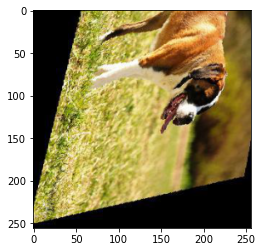

In [3]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers

In [4]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

In [5]:
learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 200

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 67.68998289108276
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 63.84929418563843
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 63.07009935379028
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 63.236133337020874
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 62.108588218688965
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 60.90768551826477
Current training loss:3.5391812324523926
Current training accuracy:0.0634765625
Current validation loss:3.5208911895751953
Current validation accuracy:0.053715307265520096
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 52.73277521133423
Current training loss:3.5046746730804443
Current training accuracy:0.06396484375
Current validation loss:3.488842725753784
Current validation accuracy:0.0626678615808487
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 49.94701862335205
Current training loss:3.5

Current training loss:3.4352285861968994
Current training accuracy:0.072265625
Current validation loss:3.3882782459259033
Current validation accuracy:0.06893464922904968
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 43.81462097167969
Current training loss:3.4154510498046875
Current training accuracy:0.0849609375
Current validation loss:3.3657405376434326
Current validation accuracy:0.0922112837433815
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 43.62039256095886
Current training loss:3.416550397872925
Current training accuracy:0.08544921875
Current validation loss:3.3470239639282227
Current validation accuracy:0.09758280962705612
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 32.583515644073486
Current training loss:3.41107177734375
Current training accuracy:0.08447265625
Current validation loss:3.360083818435669
Current validation accuracy:0.09400179237127304
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 32.63817358016968

Current training loss:3.1698827743530273
Current training accuracy:0.14208984375
Current validation loss:3.0601859092712402
Current validation accuracy:0.1665174514055252
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 33.31768488883972
Current training loss:3.156158924102783
Current training accuracy:0.15234375
Current validation loss:3.0473268032073975
Current validation accuracy:0.16293643414974213
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 33.2818169593811
Current training loss:3.225269079208374
Current training accuracy:0.11962890625
Current validation loss:3.088047742843628
Current validation accuracy:0.15129812061786652
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 33.59899950027466
Current training loss:3.1857810020446777
Current training accuracy:0.14208984375
Current validation loss:3.0734362602233887
Current validation accuracy:0.17636527121067047
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 31.27369713783

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 31.386457681655884
Current training loss:3.0250766277313232
Current training accuracy:0.18994140625
Current validation loss:2.918002128601074
Current validation accuracy:0.1996418982744217
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 31.524988651275635
Current training loss:2.98736572265625
Current training accuracy:0.19287109375
Current validation loss:2.8441338539123535
Current validation accuracy:0.21844226121902466
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 31.16060471534729
Current training loss:3.001854419708252
Current training accuracy:0.18359375
Current validation loss:2.9092471599578857
Current validation accuracy:0.18621307611465454
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 31.64366364479065
Current training loss:2.9860005378723145
Current training accuracy:0.18408203125
Current validation loss:2.8763256072998047
Current validation accuracy:0.198746636509

Current validation loss:2.7007997035980225
Current validation accuracy:0.2685765326023102
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 31.556988954544067
Current training loss:2.964421033859253
Current training accuracy:0.197265625
Current validation loss:2.833160400390625
Current validation accuracy:0.2229185253381729
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 31.86544632911682
Current training loss:2.9206290245056152
Current training accuracy:0.20751953125
Current validation loss:2.755032539367676
Current validation accuracy:0.2506714463233948
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 32.01896929740906
Current training loss:2.8560421466827393
Current training accuracy:0.22021484375
Current validation loss:2.7421743869781494
Current validation accuracy:0.24888093769550323
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 32.686870098114014
Current training loss:2.876336097717285
Current training accuracy:0.2236328

Current training loss:2.6942977905273438
Current training accuracy:0.25732421875
Current validation loss:2.5879642963409424
Current validation accuracy:0.2918531894683838
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 31.49124789237976
Current training loss:2.706693410873413
Current training accuracy:0.2705078125
Current validation loss:2.5967907905578613
Current validation accuracy:0.28111010789871216
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 31.58500647544861
Current training loss:2.6884543895721436
Current training accuracy:0.2666015625
Current validation loss:2.558870553970337
Current validation accuracy:0.3070725202560425
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 31.459017753601074
Current training loss:2.6969971656799316
Current training accuracy:0.26611328125
Current validation loss:2.562756061553955
Current validation accuracy:0.3061772584915161
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 32.0718028545

Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 32.61924767494202
Current training loss:2.504406452178955
Current training accuracy:0.31591796875
Current validation loss:2.40177059173584
Current validation accuracy:0.3303491473197937
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 31.328989505767822
Current training loss:2.5078747272491455
Current training accuracy:0.3154296875
Current validation loss:2.4319772720336914
Current validation accuracy:0.32318711280822754
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 31.495238304138184
Current training loss:2.4926602840423584
Current training accuracy:0.31201171875
Current validation loss:2.4851274490356445
Current validation accuracy:0.31154879927635193
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 30.89225697517395
Current training loss:2.5816612243652344
Current training accuracy:0.28857421875
Current validation loss:2.5144715309143066
Current validation accuracy:0.31692

Current validation loss:2.4236574172973633
Current validation accuracy:0.3393017053604126
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 31.37124729156494
Current training loss:2.4701621532440186
Current training accuracy:0.33154296875
Current validation loss:2.399768114089966
Current validation accuracy:0.3393017053604126
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 30.43660831451416
Current training loss:2.486515760421753
Current training accuracy:0.31787109375
Current validation loss:2.4517438411712646
Current validation accuracy:0.3213965892791748
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 31.063349962234497
Current training loss:2.4101693630218506
Current training accuracy:0.3505859375
Current validation loss:2.393418312072754
Current validation accuracy:0.3357206881046295
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 30.90059232711792
Current training loss:2.4451522827148438
Current training accuracy:0.336

Current training loss:2.378246545791626
Current training accuracy:0.353515625
Current validation loss:2.3045945167541504
Current validation accuracy:0.3634735941886902
Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 30.51622176170349
Current training loss:2.789283275604248
Current training accuracy:0.2451171875
Current validation loss:2.723457098007202
Current validation accuracy:0.261414498090744
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 30.945733308792114
Current training loss:2.6859257221221924
Current training accuracy:0.27880859375
Current validation loss:2.594331979751587
Current validation accuracy:0.29632946848869324
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 30.84909462928772
Current training loss:2.6350197792053223
Current training accuracy:0.28662109375
Current validation loss:2.5303256511688232
Current validation accuracy:0.2981199622154236
Epoch:51
Iteration:13500
Time taken for the last 50 iterations: 30.923245906

Epoch:57
Iteration:14950
Time taken for the last 50 iterations: 32.27597618103027
Current training loss:2.290311813354492
Current training accuracy:0.38427734375
Current validation loss:2.290713310241699
Current validation accuracy:0.36436885595321655
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 31.534091472625732
Current training loss:2.358231782913208
Current training accuracy:0.36767578125
Current validation loss:2.2873640060424805
Current validation accuracy:0.3625783324241638
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 31.11404514312744
Current training loss:2.326504707336426
Current training accuracy:0.38232421875
Current validation loss:2.271224021911621
Current validation accuracy:0.38227394223213196
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 31.783272743225098
Current training loss:2.323317050933838
Current training accuracy:0.3681640625
Current validation loss:2.2806239128112793
Current validation accuracy:0.36257833

Current validation loss:2.2752833366394043
Current validation accuracy:0.38854074478149414
Epoch:63
Iteration:16600
Time taken for the last 50 iterations: 32.957515239715576
Current training loss:2.298576593399048
Current training accuracy:0.37890625
Current validation loss:2.251784324645996
Current validation accuracy:0.3876454830169678
Epoch:63
Iteration:16650
Time taken for the last 50 iterations: 33.17865228652954
Current training loss:2.3610074520111084
Current training accuracy:0.3525390625
Current validation loss:2.2918169498443604
Current validation accuracy:0.36436885595321655
Epoch:63
Iteration:16700
Time taken for the last 50 iterations: 33.212026596069336
Current training loss:2.266632080078125
Current training accuracy:0.38671875
Current validation loss:2.259207010269165
Current validation accuracy:0.38585495948791504
Epoch:64
Iteration:16750
Time taken for the last 50 iterations: 32.65717625617981
Current training loss:2.293567419052124
Current training accuracy:0.3686523

Current training loss:2.1721391677856445
Current training accuracy:0.41259765625
Current validation loss:2.1682820320129395
Current validation accuracy:0.39122650027275085
Epoch:69
Iteration:18250
Time taken for the last 50 iterations: 34.6946656703949
Current training loss:2.174940347671509
Current training accuracy:0.40869140625
Current validation loss:2.1619770526885986
Current validation accuracy:0.38854074478149414
Epoch:70
Iteration:18300
Time taken for the last 50 iterations: 33.871230602264404
Current training loss:2.130718469619751
Current training accuracy:0.4443359375
Current validation loss:2.1421549320220947
Current validation accuracy:0.39122650027275085
Epoch:70
Iteration:18350
Time taken for the last 50 iterations: 34.4890992641449
Current training loss:2.2191998958587646
Current training accuracy:0.36767578125
Current validation loss:2.177309036254883
Current validation accuracy:0.38854074478149414
Epoch:70
Iteration:18400
Time taken for the last 50 iterations: 33.8688

Epoch:76
Iteration:19850
Time taken for the last 50 iterations: 34.0124785900116
Current training loss:2.2198593616485596
Current training accuracy:0.412109375
Current validation loss:2.1660356521606445
Current validation accuracy:0.3894359767436981
Epoch:76
Iteration:19900
Time taken for the last 50 iterations: 34.82800602912903
Current training loss:2.1968259811401367
Current training accuracy:0.40771484375
Current validation loss:2.1672253608703613
Current validation accuracy:0.39391225576400757
Epoch:76
Iteration:19950
Time taken for the last 50 iterations: 34.40124535560608
Current training loss:2.1867010593414307
Current training accuracy:0.40869140625
Current validation loss:2.162569999694824
Current validation accuracy:0.4019695520401001
Epoch:76
Iteration:20000
Time taken for the last 50 iterations: 34.75917673110962
Current training loss:2.1388866901397705
Current training accuracy:0.41748046875
Current validation loss:2.134547472000122
Current validation accuracy:0.387645483

Current validation loss:2.1474461555480957
Current validation accuracy:0.3804834485054016
Epoch:82
Iteration:21500
Time taken for the last 50 iterations: 31.50215721130371
Current training loss:2.1307663917541504
Current training accuracy:0.41357421875
Current validation loss:2.1450469493865967
Current validation accuracy:0.38854074478149414
Epoch:82
Iteration:21550
Time taken for the last 50 iterations: 32.91662001609802
Current training loss:2.075270652770996
Current training accuracy:0.4453125
Current validation loss:2.092186212539673
Current validation accuracy:0.40913161635398865
Epoch:82
Iteration:21600
Time taken for the last 50 iterations: 31.379220962524414
Current training loss:2.141047716140747
Current training accuracy:0.43017578125
Current validation loss:2.135014772415161
Current validation accuracy:0.40376007556915283
Epoch:82
Iteration:21650
Time taken for the last 50 iterations: 32.060672998428345
Current training loss:2.115581512451172
Current training accuracy:0.4291

Current training loss:2.1048805713653564
Current training accuracy:0.4423828125
Current validation loss:2.124018669128418
Current validation accuracy:0.41181737184524536
Epoch:88
Iteration:23150
Time taken for the last 50 iterations: 35.510268211364746
Current training loss:2.100973129272461
Current training accuracy:0.42919921875
Current validation loss:2.0987720489501953
Current validation accuracy:0.4198746681213379
Epoch:88
Iteration:23200
Time taken for the last 50 iterations: 35.585992097854614
Current training loss:2.1031785011291504
Current training accuracy:0.41650390625
Current validation loss:2.1417627334594727
Current validation accuracy:0.4082363545894623
Epoch:89
Iteration:23250
Time taken for the last 50 iterations: 34.89323043823242
Current training loss:2.065934896469116
Current training accuracy:0.4501953125
Current validation loss:2.0870277881622314
Current validation accuracy:0.4145031273365021
Epoch:89
Iteration:23300
Time taken for the last 50 iterations: 35.59786

Epoch:94
Iteration:24750
Time taken for the last 50 iterations: 30.438931465148926
Current training loss:1.9848787784576416
Current training accuracy:0.4619140625
Current validation loss:2.034877300262451
Current validation accuracy:0.4162936508655548
Epoch:95
Iteration:24800
Time taken for the last 50 iterations: 29.632734775543213
Current training loss:2.102956771850586
Current training accuracy:0.44677734375
Current validation loss:2.1769611835479736
Current validation accuracy:0.3921217620372772
Epoch:95
Iteration:24850
Time taken for the last 50 iterations: 30.284181594848633
Current training loss:2.080740451812744
Current training accuracy:0.43701171875
Current validation loss:2.134316921234131
Current validation accuracy:0.3930170238018036
Epoch:95
Iteration:24900
Time taken for the last 50 iterations: 30.20274066925049
Current training loss:2.0416533946990967
Current training accuracy:0.46630859375
Current validation loss:2.067704200744629
Current validation accuracy:0.42166516

Current validation loss:2.138596296310425
Current validation accuracy:0.4055505692958832
Epoch:101
Iteration:26400
Time taken for the last 50 iterations: 29.708332061767578
Current training loss:2.2593038082122803
Current training accuracy:0.39208984375
Current validation loss:2.253493070602417
Current validation accuracy:0.3634735941886902
Epoch:101
Iteration:26450
Time taken for the last 50 iterations: 30.222856998443604
Current training loss:2.216825008392334
Current training accuracy:0.40283203125
Current validation loss:2.2203586101531982
Current validation accuracy:0.3867502212524414
Epoch:101
Iteration:26500
Time taken for the last 50 iterations: 29.71789264678955
Current training loss:2.21201491355896
Current training accuracy:0.3994140625
Current validation loss:2.2274086475372314
Current validation accuracy:0.3751119077205658
Epoch:101
Iteration:26550
Time taken for the last 50 iterations: 30.0989933013916
Current training loss:2.1325747966766357
Current training accuracy:0.4

Current training loss:1.9245233535766602
Current training accuracy:0.47119140625
Current validation loss:2.037753105163574
Current validation accuracy:0.4252462089061737
Epoch:107
Iteration:28050
Time taken for the last 50 iterations: 30.65151572227478
Current training loss:1.908428430557251
Current training accuracy:0.50341796875
Current validation loss:2.026205539703369
Current validation accuracy:0.43330350518226624
Epoch:107
Iteration:28100
Time taken for the last 50 iterations: 30.866660356521606
Current training loss:1.9561128616333008
Current training accuracy:0.46630859375
Current validation loss:2.0083022117614746
Current validation accuracy:0.4341987371444702
Epoch:107
Iteration:28150
Time taken for the last 50 iterations: 31.285069704055786
Current training loss:1.8870625495910645
Current training accuracy:0.4853515625
Current validation loss:2.0011188983917236
Current validation accuracy:0.42972245812416077
Epoch:108
Iteration:28200
Time taken for the last 50 iterations: 30

Epoch:113
Iteration:29650
Time taken for the last 50 iterations: 33.61891484260559
Current training loss:1.8985106945037842
Current training accuracy:0.5029296875
Current validation loss:2.009605884552002
Current validation accuracy:0.4404655396938324
Epoch:113
Iteration:29700
Time taken for the last 50 iterations: 33.5005784034729
Current training loss:1.9112719297409058
Current training accuracy:0.49853515625
Current validation loss:2.0088553428649902
Current validation accuracy:0.4467323124408722
Epoch:113
Iteration:29750
Time taken for the last 50 iterations: 33.463019132614136
Current training loss:1.8925061225891113
Current training accuracy:0.49658203125
Current validation loss:1.9869897365570068
Current validation accuracy:0.42076992988586426
Epoch:114
Iteration:29800
Time taken for the last 50 iterations: 32.818864822387695
Current training loss:2.001037359237671
Current training accuracy:0.470703125
Current validation loss:2.062338352203369
Current validation accuracy:0.41271

Current validation loss:1.9720221757888794
Current validation accuracy:0.4494180977344513
Epoch:119
Iteration:31300
Time taken for the last 50 iterations: 36.193029165267944
Current training loss:1.8412253856658936
Current training accuracy:0.5361328125
Current validation loss:1.9533791542053223
Current validation accuracy:0.4458370506763458
Epoch:120
Iteration:31350
Time taken for the last 50 iterations: 35.907050371170044
Current training loss:1.8288050889968872
Current training accuracy:0.53271484375
Current validation loss:1.9712008237838745
Current validation accuracy:0.43330350518226624
Epoch:120
Iteration:31400
Time taken for the last 50 iterations: 36.50766396522522
Current training loss:1.8066043853759766
Current training accuracy:0.54345703125
Current validation loss:1.9583444595336914
Current validation accuracy:0.4404655396938324
Epoch:120
Iteration:31450
Time taken for the last 50 iterations: 36.4303674697876
Current training loss:1.8458929061889648
Current training accura

Current training loss:2.2158308029174805
Current training accuracy:0.4189453125
Current validation loss:2.2424612045288086
Current validation accuracy:0.38495972752571106
Epoch:126
Iteration:32950
Time taken for the last 50 iterations: 39.672873973846436
Current training loss:1.9575815200805664
Current training accuracy:0.482421875
Current validation loss:2.0817205905914307
Current validation accuracy:0.41271263360977173
Epoch:126
Iteration:33000
Time taken for the last 50 iterations: 39.79112648963928
Current training loss:1.9434716701507568
Current training accuracy:0.5009765625
Current validation loss:2.049365282058716
Current validation accuracy:0.42345568537712097
Epoch:126
Iteration:33050
Time taken for the last 50 iterations: 39.93742370605469
Current training loss:1.9227951765060425
Current training accuracy:0.5029296875
Current validation loss:2.019296646118164
Current validation accuracy:0.43330350518226624
Epoch:126
Iteration:33100
Time taken for the last 50 iterations: 40.0

Epoch:132
Iteration:34550
Time taken for the last 50 iterations: 39.09879112243652
Current training loss:1.897338628768921
Current training accuracy:0.52734375
Current validation loss:2.046332836151123
Current validation accuracy:0.42345568537712097
Epoch:132
Iteration:34600
Time taken for the last 50 iterations: 39.456790924072266
Current training loss:1.966902494430542
Current training accuracy:0.4794921875
Current validation loss:2.069596290588379
Current validation accuracy:0.4082363545894623
Epoch:132
Iteration:34650
Time taken for the last 50 iterations: 39.299712896347046
Current training loss:1.9213528633117676
Current training accuracy:0.501953125
Current validation loss:2.047312021255493
Current validation accuracy:0.42435094714164734
Epoch:132
Iteration:34700
Time taken for the last 50 iterations: 39.174721240997314
Current training loss:1.8859676122665405
Current training accuracy:0.50830078125
Current validation loss:2.015333414077759
Current validation accuracy:0.42793196

Current validation loss:1.9799717664718628
Current validation accuracy:0.42076992988586426
Epoch:138
Iteration:36200
Time taken for the last 50 iterations: 39.124706745147705
Current training loss:1.7843987941741943
Current training accuracy:0.52783203125
Current validation loss:1.971815586090088
Current validation accuracy:0.42166516184806824
Epoch:138
Iteration:36250
Time taken for the last 50 iterations: 39.02725100517273
Current training loss:1.8265469074249268
Current training accuracy:0.53076171875
Current validation loss:1.964216947555542
Current validation accuracy:0.43061771988868713
Epoch:139
Iteration:36300
Time taken for the last 50 iterations: 37.95982003211975
Current training loss:1.783560037612915
Current training accuracy:0.53955078125
Current validation loss:1.9449750185012817
Current validation accuracy:0.4404655396938324
Epoch:139
Iteration:36350
Time taken for the last 50 iterations: 38.93965291976929
Current training loss:1.7894529104232788
Current training accura

Epoch:144
Iteration:37800
Time taken for the last 50 iterations: 39.55186605453491
Current training loss:1.7077622413635254
Current training accuracy:0.5595703125
Current validation loss:1.8966922760009766
Current validation accuracy:0.452103853225708
Epoch:145
Iteration:37850
Time taken for the last 50 iterations: 38.8549382686615
Current training loss:1.772372841835022
Current training accuracy:0.54052734375
Current validation loss:1.93583345413208
Current validation accuracy:0.4368845224380493
Epoch:145
Iteration:37900
Time taken for the last 50 iterations: 39.63025403022766
Current training loss:1.74337899684906
Current training accuracy:0.55712890625
Current validation loss:1.9127259254455566
Current validation accuracy:0.44136080145835876
Epoch:145
Iteration:37950
Time taken for the last 50 iterations: 39.40487456321716
Current training loss:1.740648627281189
Current training accuracy:0.56640625
Current validation loss:1.9162304401397705
Current validation accuracy:0.448522835969

Current validation loss:1.916990876197815
Current validation accuracy:0.4404655396938324
Epoch:151
Iteration:39450
Time taken for the last 50 iterations: 41.6682186126709
Current training loss:1.8975908756256104
Current training accuracy:0.498046875
Current validation loss:2.087864637374878
Current validation accuracy:0.42076992988586426
Epoch:151
Iteration:39500
Time taken for the last 50 iterations: 42.77443528175354
Current training loss:1.893894076347351
Current training accuracy:0.51171875
Current validation loss:2.0417706966400146
Current validation accuracy:0.4162936508655548
Epoch:151
Iteration:39550
Time taken for the last 50 iterations: 42.88475155830383
Current training loss:1.858907699584961
Current training accuracy:0.53662109375
Current validation loss:1.9831326007843018
Current validation accuracy:0.4350939989089966
Epoch:151
Iteration:39600
Time taken for the last 50 iterations: 56.36404371261597
Current training loss:1.7751057147979736
Current training accuracy:0.55371

Current training loss:1.7933032512664795
Current training accuracy:0.5341796875
Current validation loss:1.9413083791732788
Current validation accuracy:0.4377797544002533
Epoch:157
Iteration:41100
Time taken for the last 50 iterations: 55.49905252456665
Current training loss:1.7644916772842407
Current training accuracy:0.55126953125
Current validation loss:1.9566329717636108
Current validation accuracy:0.4377797544002533
Epoch:157
Iteration:41150
Time taken for the last 50 iterations: 58.21506953239441
Current training loss:1.7449710369110107
Current training accuracy:0.544921875
Current validation loss:1.9218968152999878
Current validation accuracy:0.4431512951850891
Epoch:157
Iteration:41200
Time taken for the last 50 iterations: 55.154829025268555
Current training loss:1.703229546546936
Current training accuracy:0.57666015625
Current validation loss:1.9287647008895874
Current validation accuracy:0.4494180977344513
Epoch:158
Iteration:41250
Time taken for the last 50 iterations: 55.24

Epoch:163
Iteration:42700
Time taken for the last 50 iterations: 64.53282475471497
Current training loss:1.733054757118225
Current training accuracy:0.56689453125
Current validation loss:1.9010637998580933
Current validation accuracy:0.46553269028663635
Epoch:163
Iteration:42750
Time taken for the last 50 iterations: 69.83417248725891
Current training loss:1.7380845546722412
Current training accuracy:0.5439453125
Current validation loss:1.9144948720932007
Current validation accuracy:0.4494180977344513
Epoch:163
Iteration:42800
Time taken for the last 50 iterations: 80.19338202476501
Current training loss:1.6686480045318604
Current training accuracy:0.57568359375
Current validation loss:1.9020106792449951
Current validation accuracy:0.46821844577789307
Epoch:164
Iteration:42850
Time taken for the last 50 iterations: 57.432443618774414
Current training loss:1.6803736686706543
Current training accuracy:0.57763671875
Current validation loss:1.901391625404358
Current validation accuracy:0.4

Current validation loss:1.8778835535049438
Current validation accuracy:0.45926588773727417
Epoch:169
Iteration:44350
Time taken for the last 50 iterations: 47.37173080444336
Current training loss:1.6450228691101074
Current training accuracy:0.56982421875
Current validation loss:1.879307508468628
Current validation accuracy:0.46642792224884033
Epoch:170
Iteration:44400
Time taken for the last 50 iterations: 46.34357953071594
Current training loss:1.9281458854675293
Current training accuracy:0.47216796875
Current validation loss:2.097712278366089
Current validation accuracy:0.4136078655719757
Epoch:170
Iteration:44450
Time taken for the last 50 iterations: 47.59281039237976
Current training loss:1.8292285203933716
Current training accuracy:0.521484375
Current validation loss:2.0280990600585938
Current validation accuracy:0.4288272261619568
Epoch:170
Iteration:44500
Time taken for the last 50 iterations: 47.51363277435303
Current training loss:1.7866767644882202
Current training accuracy:

Current training loss:1.5764102935791016
Current training accuracy:0.6044921875
Current validation loss:1.8875685930252075
Current validation accuracy:0.4762757420539856
Epoch:176
Iteration:46000
Time taken for the last 50 iterations: 51.0533766746521
Current training loss:1.6125353574752808
Current training accuracy:0.59033203125
Current validation loss:1.8644235134124756
Current validation accuracy:0.4905998110771179
Epoch:176
Iteration:46050
Time taken for the last 50 iterations: 50.66321659088135
Current training loss:1.637683391571045
Current training accuracy:0.5888671875
Current validation loss:1.8631850481033325
Current validation accuracy:0.4619516432285309
Epoch:176
Iteration:46100
Time taken for the last 50 iterations: 50.96292519569397
Current training loss:1.645532488822937
Current training accuracy:0.5966796875
Current validation loss:1.8877967596054077
Current validation accuracy:0.46642792224884033
Epoch:176
Iteration:46150
Time taken for the last 50 iterations: 51.0003

Epoch:182
Iteration:47600
Time taken for the last 50 iterations: 51.768994092941284
Current training loss:1.6423401832580566
Current training accuracy:0.58203125
Current validation loss:1.885451316833496
Current validation accuracy:0.4726947247982025
Epoch:182
Iteration:47650
Time taken for the last 50 iterations: 51.99376726150513
Current training loss:1.6013370752334595
Current training accuracy:0.60888671875
Current validation loss:1.8808836936950684
Current validation accuracy:0.4637421667575836
Epoch:182
Iteration:47700
Time taken for the last 50 iterations: 52.0322949886322
Current training loss:1.6170870065689087
Current training accuracy:0.59130859375
Current validation loss:1.8795822858810425
Current validation accuracy:0.4735899865627289
Epoch:182
Iteration:47750
Time taken for the last 50 iterations: 51.702022552490234
Current training loss:1.6599156856536865
Current training accuracy:0.5830078125
Current validation loss:1.8957222700119019
Current validation accuracy:0.46284

Current validation loss:1.903786063194275
Current validation accuracy:0.45926588773727417
Epoch:188
Iteration:49250
Time taken for the last 50 iterations: 51.42427897453308
Current training loss:1.6421674489974976
Current training accuracy:0.583984375
Current validation loss:1.8667608499526978
Current validation accuracy:0.4726947247982025
Epoch:188
Iteration:49300
Time taken for the last 50 iterations: 51.48825168609619
Current training loss:1.6174198389053345
Current training accuracy:0.6083984375
Current validation loss:1.8750931024551392
Current validation accuracy:0.47448521852493286
Epoch:189
Iteration:49350
Time taken for the last 50 iterations: 50.4007785320282
Current training loss:1.7971065044403076
Current training accuracy:0.53759765625
Current validation loss:1.9755487442016602
Current validation accuracy:0.42703670263290405
Epoch:189
Iteration:49400
Time taken for the last 50 iterations: 51.32141923904419
Current training loss:1.759395956993103
Current training accuracy:0

Current training loss:1.5833626985549927
Current training accuracy:0.6083984375
Current validation loss:1.8628123998641968
Current validation accuracy:0.47448521852493286
Epoch:195
Iteration:50900
Time taken for the last 50 iterations: 47.88408660888672
Current training loss:2.0412957668304443
Current training accuracy:0.5048828125
Current validation loss:2.217259407043457
Current validation accuracy:0.4100268483161926
Epoch:195
Iteration:50950
Time taken for the last 50 iterations: 49.4439218044281
Current training loss:1.7174257040023804
Current training accuracy:0.54052734375
Current validation loss:1.9753785133361816
Current validation accuracy:0.4431512951850891
Epoch:195
Iteration:51000
Time taken for the last 50 iterations: 49.23619818687439
Current training loss:1.7078561782836914
Current training accuracy:0.57177734375
Current validation loss:1.944931983947754
Current validation accuracy:0.4494180977344513
Epoch:195
Iteration:51050
Time taken for the last 50 iterations: 49.255

In [6]:
num_epochs=150

start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                


Epoch:0
Iteration:52250
Time taken for the last 50 iterations: 48.649895906448364
Epoch:0
Iteration:52300
Time taken for the last 50 iterations: 49.45180940628052
Epoch:0
Iteration:52350
Time taken for the last 50 iterations: 49.86306858062744
Epoch:0
Iteration:52400
Time taken for the last 50 iterations: 49.94440817832947
Epoch:0
Iteration:52450
Time taken for the last 50 iterations: 50.01185631752014
Epoch:1
Iteration:52500
Time taken for the last 50 iterations: 48.691011905670166
Current training loss:1.7224167585372925
Current training accuracy:0.55322265625
Current validation loss:1.9509974718093872
Current validation accuracy:0.4377797544002533
Epoch:1
Iteration:52550
Time taken for the last 50 iterations: 47.67137026786804
Current training loss:1.6981415748596191
Current training accuracy:0.5859375
Current validation loss:1.9254885911941528
Current validation accuracy:0.4503133296966553
Epoch:1
Iteration:52600
Time taken for the last 50 iterations: 48.6291446685791
Current train

Current training loss:1.616464376449585
Current training accuracy:0.5810546875
Current validation loss:1.9010404348373413
Current validation accuracy:0.4494180977344513
Epoch:7
Iteration:54100
Time taken for the last 50 iterations: 48.05267786979675
Current training loss:1.5739368200302124
Current training accuracy:0.61328125
Current validation loss:1.8870279788970947
Current validation accuracy:0.4619516432285309
Epoch:7
Iteration:54150
Time taken for the last 50 iterations: 48.500964641571045
Current training loss:1.5997307300567627
Current training accuracy:0.6181640625
Current validation loss:1.8626662492752075
Current validation accuracy:0.4798567593097687
Epoch:7
Iteration:54200
Time taken for the last 50 iterations: 48.989461183547974
Current training loss:1.5469589233398438
Current training accuracy:0.60546875
Current validation loss:1.868516206741333
Current validation accuracy:0.46553269028663635
Epoch:7
Iteration:54250
Time taken for the last 50 iterations: 48.91119360923767

Epoch:13
Iteration:55700
Time taken for the last 50 iterations: 48.07776999473572
Current training loss:1.677191972732544
Current training accuracy:0.58349609375
Current validation loss:1.9241949319839478
Current validation accuracy:0.4529991149902344
Epoch:13
Iteration:55750
Time taken for the last 50 iterations: 48.256266593933105
Current training loss:1.6314281225204468
Current training accuracy:0.60498046875
Current validation loss:1.8962987661361694
Current validation accuracy:0.4619516432285309
Epoch:13
Iteration:55800
Time taken for the last 50 iterations: 48.499706506729126
Current training loss:1.5896869897842407
Current training accuracy:0.62548828125
Current validation loss:1.9071065187454224
Current validation accuracy:0.4574753940105438
Epoch:13
Iteration:55850
Time taken for the last 50 iterations: 48.3858060836792
Current training loss:1.5894654989242554
Current training accuracy:0.5986328125
Current validation loss:1.8910149335861206
Current validation accuracy:0.452999

Current validation loss:1.8619871139526367
Current validation accuracy:0.4709042012691498
Epoch:19
Iteration:57350
Time taken for the last 50 iterations: 50.43932914733887
Current training loss:1.6078087091445923
Current training accuracy:0.6240234375
Current validation loss:1.8649952411651611
Current validation accuracy:0.4762757420539856
Epoch:19
Iteration:57400
Time taken for the last 50 iterations: 50.43639659881592
Current training loss:1.5800074338912964
Current training accuracy:0.61669921875
Current validation loss:1.8625125885009766
Current validation accuracy:0.4700089395046234
Epoch:20
Iteration:57450
Time taken for the last 50 iterations: 49.2372350692749
Current training loss:1.7277567386627197
Current training accuracy:0.55859375
Current validation loss:1.9189248085021973
Current validation accuracy:0.4503133296966553
Epoch:20
Iteration:57500
Time taken for the last 50 iterations: 50.518393993377686
Current training loss:1.702385663986206
Current training accuracy:0.55419

Current training loss:1.7125226259231567
Current training accuracy:0.57666015625
Current validation loss:1.9534447193145752
Current validation accuracy:0.44494181871414185
Epoch:26
Iteration:59000
Time taken for the last 50 iterations: 48.769609689712524
Current training loss:1.7256253957748413
Current training accuracy:0.57177734375
Current validation loss:1.9432944059371948
Current validation accuracy:0.4440465569496155
Epoch:26
Iteration:59050
Time taken for the last 50 iterations: 49.72693657875061
Current training loss:1.6640876531600952
Current training accuracy:0.599609375
Current validation loss:1.9095512628555298
Current validation accuracy:0.45926588773727417
Epoch:26
Iteration:59100
Time taken for the last 50 iterations: 49.42187452316284
Current training loss:1.7187702655792236
Current training accuracy:0.5771484375
Current validation loss:1.922515869140625
Current validation accuracy:0.4494180977344513
Epoch:26
Iteration:59150
Time taken for the last 50 iterations: 49.7334

Epoch:32
Iteration:60600
Time taken for the last 50 iterations: 48.55898427963257
Current training loss:1.598487138748169
Current training accuracy:0.59619140625
Current validation loss:1.9001299142837524
Current validation accuracy:0.46016114950180054
Epoch:32
Iteration:60650
Time taken for the last 50 iterations: 49.72021555900574
Current training loss:1.615991473197937
Current training accuracy:0.59619140625
Current validation loss:1.8782191276550293
Current validation accuracy:0.46911370754241943
Epoch:32
Iteration:60700
Time taken for the last 50 iterations: 49.344571590423584
Current training loss:1.5817805528640747
Current training accuracy:0.61865234375
Current validation loss:1.8575975894927979
Current validation accuracy:0.46821844577789307
Epoch:32
Iteration:60750
Time taken for the last 50 iterations: 49.458029985427856
Current training loss:1.6047098636627197
Current training accuracy:0.6005859375
Current validation loss:1.8472306728363037
Current validation accuracy:0.469

Current validation loss:1.9528721570968628
Current validation accuracy:0.4467323124408722
Epoch:38
Iteration:62250
Time taken for the last 50 iterations: 48.030768394470215
Current training loss:1.656153917312622
Current training accuracy:0.5771484375
Current validation loss:1.8867666721343994
Current validation accuracy:0.4673231840133667
Epoch:38
Iteration:62300
Time taken for the last 50 iterations: 48.23672866821289
Current training loss:1.6447994709014893
Current training accuracy:0.58349609375
Current validation loss:1.8942652940750122
Current validation accuracy:0.45658013224601746
Epoch:38
Iteration:62350
Time taken for the last 50 iterations: 48.61528944969177
Current training loss:1.6217137575149536
Current training accuracy:0.607421875
Current validation loss:1.8781148195266724
Current validation accuracy:0.46911370754241943
Epoch:39
Iteration:62400
Time taken for the last 50 iterations: 47.61411738395691
Current training loss:1.6161385774612427
Current training accuracy:0.6

Current training loss:1.4746171236038208
Current training accuracy:0.658203125
Current validation loss:1.8072926998138428
Current validation accuracy:0.4879140555858612
Epoch:44
Iteration:63900
Time taken for the last 50 iterations: 47.73490905761719
Current training loss:1.519187569618225
Current training accuracy:0.64697265625
Current validation loss:1.8472421169281006
Current validation accuracy:0.47448521852493286
Epoch:45
Iteration:63950
Time taken for the last 50 iterations: 46.896623611450195
Current training loss:1.5612123012542725
Current training accuracy:0.6279296875
Current validation loss:1.8383911848068237
Current validation accuracy:0.46821844577789307
Epoch:45
Iteration:64000
Time taken for the last 50 iterations: 47.6899197101593
Current training loss:1.4676809310913086
Current training accuracy:0.65185546875
Current validation loss:1.820879340171814
Current validation accuracy:0.4762757420539856
Epoch:45
Iteration:64050
Time taken for the last 50 iterations: 47.774046

Epoch:50
Iteration:65500
Time taken for the last 50 iterations: 50.17400407791138
Current training loss:1.5176950693130493
Current training accuracy:0.6142578125
Current validation loss:1.8046711683273315
Current validation accuracy:0.4879140555858612
Epoch:51
Iteration:65550
Time taken for the last 50 iterations: 49.81704330444336
Current training loss:1.5520408153533936
Current training accuracy:0.609375
Current validation loss:1.8739583492279053
Current validation accuracy:0.4619516432285309
Epoch:51
Iteration:65600
Time taken for the last 50 iterations: 50.69177770614624
Current training loss:1.6212002038955688
Current training accuracy:0.5986328125
Current validation loss:1.8808021545410156
Current validation accuracy:0.45926588773727417
Epoch:51
Iteration:65650
Time taken for the last 50 iterations: 50.74345636367798
Current training loss:1.5652838945388794
Current training accuracy:0.61474609375
Current validation loss:1.8422033786773682
Current validation accuracy:0.47090420126

Current validation loss:2.0600717067718506
Current validation accuracy:0.4467323124408722
Epoch:57
Iteration:67150
Time taken for the last 50 iterations: 52.313262701034546
Current training loss:1.6827847957611084
Current training accuracy:0.58984375
Current validation loss:1.9600361585617065
Current validation accuracy:0.452103853225708
Epoch:57
Iteration:67200
Time taken for the last 50 iterations: 52.353983879089355
Current training loss:1.6904469728469849
Current training accuracy:0.58935546875
Current validation loss:1.9332449436187744
Current validation accuracy:0.4610564112663269
Epoch:57
Iteration:67250
Time taken for the last 50 iterations: 52.38482332229614
Current training loss:1.6087102890014648
Current training accuracy:0.60595703125
Current validation loss:1.8970531225204468
Current validation accuracy:0.4574753940105438
Epoch:57
Iteration:67300
Time taken for the last 50 iterations: 52.467432260513306
Current training loss:1.5874478816986084
Current training accuracy:0.6

Current training loss:1.4667860269546509
Current training accuracy:0.6396484375
Current validation loss:1.8391894102096558
Current validation accuracy:0.4709042012691498
Epoch:63
Iteration:68800
Time taken for the last 50 iterations: 52.54807472229004
Current training loss:1.488404631614685
Current training accuracy:0.6474609375
Current validation loss:1.8456681966781616
Current validation accuracy:0.46553269028663635
Epoch:63
Iteration:68850
Time taken for the last 50 iterations: 52.44664454460144
Current training loss:1.4888216257095337
Current training accuracy:0.63134765625
Current validation loss:1.8625613451004028
Current validation accuracy:0.4673231840133667
Epoch:63
Iteration:68900
Time taken for the last 50 iterations: 52.84678316116333
Current training loss:1.4746884107589722
Current training accuracy:0.63525390625
Current validation loss:1.8530821800231934
Current validation accuracy:0.46642792224884033
Epoch:64
Iteration:68950
Time taken for the last 50 iterations: 51.7496

Epoch:69
Iteration:70400
Time taken for the last 50 iterations: 54.492841958999634
Current training loss:1.5004862546920776
Current training accuracy:0.642578125
Current validation loss:1.8431638479232788
Current validation accuracy:0.4583706259727478
Epoch:69
Iteration:70450
Time taken for the last 50 iterations: 54.622132778167725
Current training loss:1.4656741619110107
Current training accuracy:0.65673828125
Current validation loss:1.8508188724517822
Current validation accuracy:0.46642792224884033
Epoch:70
Iteration:70500
Time taken for the last 50 iterations: 53.60161995887756
Current training loss:1.6038719415664673
Current training accuracy:0.595703125
Current validation loss:1.971792459487915
Current validation accuracy:0.44225603342056274
Epoch:70
Iteration:70550
Time taken for the last 50 iterations: 54.830705404281616
Current training loss:1.580284595489502
Current training accuracy:0.62060546875
Current validation loss:1.906429409980774
Current validation accuracy:0.4583706

Current validation loss:1.796152949333191
Current validation accuracy:0.4798567593097687
Epoch:76
Iteration:72050
Time taken for the last 50 iterations: 56.61039352416992
Current training loss:1.5975981950759888
Current training accuracy:0.5947265625
Current validation loss:1.9317824840545654
Current validation accuracy:0.4467323124408722
Epoch:76
Iteration:72100
Time taken for the last 50 iterations: 57.841179609298706
Current training loss:1.5670992136001587
Current training accuracy:0.61181640625
Current validation loss:1.862744927406311
Current validation accuracy:0.47717100381851196
Epoch:76
Iteration:72150
Time taken for the last 50 iterations: 57.927014112472534
Current training loss:1.56705904006958
Current training accuracy:0.61669921875
Current validation loss:1.8563467264175415
Current validation accuracy:0.47448521852493286
Epoch:76
Iteration:72200
Time taken for the last 50 iterations: 57.937859535217285
Current training loss:1.532841444015503
Current training accuracy:0.6

Current training loss:1.6089097261428833
Current training accuracy:0.61962890625
Current validation loss:1.870653748512268
Current validation accuracy:0.4431512951850891
Epoch:82
Iteration:73700
Time taken for the last 50 iterations: 59.759483098983765
Current training loss:1.5598945617675781
Current training accuracy:0.62548828125
Current validation loss:1.8712151050567627
Current validation accuracy:0.47179946303367615
Epoch:82
Iteration:73750
Time taken for the last 50 iterations: 59.976096630096436
Current training loss:1.5224205255508423
Current training accuracy:0.63916015625
Current validation loss:1.8494234085083008
Current validation accuracy:0.4798567593097687
Epoch:82
Iteration:73800
Time taken for the last 50 iterations: 59.8623833656311
Current training loss:1.5338541269302368
Current training accuracy:0.63623046875
Current validation loss:1.8606594800949097
Current validation accuracy:0.47538048028945923
Epoch:82
Iteration:73850
Time taken for the last 50 iterations: 59.8

Epoch:88
Iteration:75300
Time taken for the last 50 iterations: 60.152454137802124
Current training loss:1.629517674446106
Current training accuracy:0.6083984375
Current validation loss:1.8806915283203125
Current validation accuracy:0.4789614975452423
Epoch:88
Iteration:75350
Time taken for the last 50 iterations: 59.94239544868469
Current training loss:1.5319297313690186
Current training accuracy:0.6240234375
Current validation loss:1.844904899597168
Current validation accuracy:0.4726947247982025
Epoch:88
Iteration:75400
Time taken for the last 50 iterations: 60.153417110443115
Current training loss:1.6018898487091064
Current training accuracy:0.6181640625
Current validation loss:1.8637406826019287
Current validation accuracy:0.46553269028663635
Epoch:89
Iteration:75450
Time taken for the last 50 iterations: 58.92746114730835
Current training loss:1.5574731826782227
Current training accuracy:0.63427734375
Current validation loss:1.8304595947265625
Current validation accuracy:0.4726947

Current validation loss:1.8471590280532837
Current validation accuracy:0.4700089395046234
Epoch:94
Iteration:76950
Time taken for the last 50 iterations: 59.482348918914795
Current training loss:1.5054354667663574
Current training accuracy:0.634765625
Current validation loss:1.8241325616836548
Current validation accuracy:0.4843330383300781
Epoch:95
Iteration:77000
Time taken for the last 50 iterations: 58.4969437122345
Current training loss:1.60120689868927
Current training accuracy:0.61328125
Current validation loss:1.8758095502853394
Current validation accuracy:0.47717100381851196
Epoch:95
Iteration:77050
Time taken for the last 50 iterations: 58.26644277572632
Current training loss:1.5835946798324585
Current training accuracy:0.62060546875
Current validation loss:1.862097978591919
Current validation accuracy:0.4556848704814911
Epoch:95
Iteration:77100
Time taken for the last 50 iterations: 58.13339304924011
Current training loss:1.528775691986084
Current training accuracy:0.62841796

Current training loss:1.4754316806793213
Current training accuracy:0.6533203125
Current validation loss:1.8001669645309448
Current validation accuracy:0.4852283000946045
Epoch:101
Iteration:78600
Time taken for the last 50 iterations: 56.184491872787476
Current training loss:1.523496389389038
Current training accuracy:0.64697265625
Current validation loss:1.8184293508529663
Current validation accuracy:0.48701879382133484
Epoch:101
Iteration:78650
Time taken for the last 50 iterations: 57.72950053215027
Current training loss:1.4930273294448853
Current training accuracy:0.6640625
Current validation loss:1.7941850423812866
Current validation accuracy:0.49239033460617065
Epoch:101
Iteration:78700
Time taken for the last 50 iterations: 57.17817449569702
Current training loss:1.5295803546905518
Current training accuracy:0.64111328125
Current validation loss:1.8190609216690063
Current validation accuracy:0.4843330383300781
Epoch:101
Iteration:78750
Time taken for the last 50 iterations: 56.62

Epoch:107
Iteration:80200
Time taken for the last 50 iterations: 52.177839517593384
Current training loss:1.5796629190444946
Current training accuracy:0.61328125
Current validation loss:1.8443541526794434
Current validation accuracy:0.4852283000946045
Epoch:107
Iteration:80250
Time taken for the last 50 iterations: 52.255526065826416
Current training loss:1.5511398315429688
Current training accuracy:0.6220703125
Current validation loss:1.8722302913665771
Current validation accuracy:0.4789614975452423
Epoch:107
Iteration:80300
Time taken for the last 50 iterations: 52.144299268722534
Current training loss:1.6217262744903564
Current training accuracy:0.6083984375
Current validation loss:1.842266321182251
Current validation accuracy:0.4789614975452423
Epoch:107
Iteration:80350
Time taken for the last 50 iterations: 51.92456674575806
Current training loss:1.5968830585479736
Current training accuracy:0.58349609375
Current validation loss:1.8683408498764038
Current validation accuracy:0.4744

Current training loss:1.6521108150482178
Current training accuracy:0.583984375
Current validation loss:1.945395827293396
Current validation accuracy:0.44225603342056274
Epoch:113
Iteration:81850
Time taken for the last 50 iterations: 52.333568811416626
Current training loss:1.6968002319335938
Current training accuracy:0.578125
Current validation loss:1.8905432224273682
Current validation accuracy:0.4726947247982025
Epoch:113
Iteration:81900
Time taken for the last 50 iterations: 52.7373480796814
Current training loss:1.5975525379180908
Current training accuracy:0.619140625
Current validation loss:1.8556097745895386
Current validation accuracy:0.4700089395046234
Epoch:113
Iteration:81950
Time taken for the last 50 iterations: 52.437644958496094
Current training loss:1.609395146369934
Current training accuracy:0.5966796875
Current validation loss:1.8731544017791748
Current validation accuracy:0.4494180977344513
Epoch:114
Iteration:82000
Time taken for the last 50 iterations: 51.242609500

Epoch:119
Iteration:83450
Time taken for the last 50 iterations: 54.099063873291016
Current training loss:1.4900590181350708
Current training accuracy:0.62890625
Current validation loss:1.8038769960403442
Current validation accuracy:0.4825425148010254
Epoch:119
Iteration:83500
Time taken for the last 50 iterations: 52.2284722328186
Current training loss:1.5322566032409668
Current training accuracy:0.6220703125
Current validation loss:1.7891520261764526
Current validation accuracy:0.47806623578071594
Epoch:120
Iteration:83550
Time taken for the last 50 iterations: 52.891626834869385
Current training loss:1.5036587715148926
Current training accuracy:0.650390625
Current validation loss:1.7973568439483643
Current validation accuracy:0.4852283000946045
Epoch:120
Iteration:83600
Time taken for the last 50 iterations: 52.57614541053772
Current training loss:1.4667332172393799
Current training accuracy:0.65234375
Current validation loss:1.8072409629821777
Current validation accuracy:0.47717100

Current validation loss:1.8142197132110596
Current validation accuracy:0.48075202107429504
Epoch:126
Iteration:85100
Time taken for the last 50 iterations: 53.17097043991089
Current training loss:1.454397439956665
Current training accuracy:0.65771484375
Current validation loss:1.8060919046401978
Current validation accuracy:0.48970457911491394
Epoch:126
Iteration:85150
Time taken for the last 50 iterations: 54.490962266922
Current training loss:1.4638890027999878
Current training accuracy:0.63330078125
Current validation loss:1.8072820901870728
Current validation accuracy:0.4825425148010254
Epoch:126
Iteration:85200
Time taken for the last 50 iterations: 54.53636026382446
Current training loss:1.4650264978408813
Current training accuracy:0.65673828125
Current validation loss:1.793595552444458
Current validation accuracy:0.4798567593097687
Epoch:126
Iteration:85250
Time taken for the last 50 iterations: 54.40545463562012
Current training loss:1.450666904449463
Current training accuracy:0

Epoch:132
Iteration:86700
Time taken for the last 50 iterations: 53.62667989730835
Current training loss:1.5044524669647217
Current training accuracy:0.63037109375
Current validation loss:1.8151048421859741
Current validation accuracy:0.4726947247982025
Epoch:132
Iteration:86750
Time taken for the last 50 iterations: 54.72951149940491
Current training loss:1.5413625240325928
Current training accuracy:0.6376953125
Current validation loss:1.8094329833984375
Current validation accuracy:0.47179946303367615
Epoch:132
Iteration:86800
Time taken for the last 50 iterations: 54.55898070335388
Current training loss:1.486037254333496
Current training accuracy:0.6474609375
Current validation loss:1.8151671886444092
Current validation accuracy:0.4798567593097687
Epoch:132
Iteration:86850
Time taken for the last 50 iterations: 54.523725748062134
Current training loss:1.5132173299789429
Current training accuracy:0.63525390625
Current validation loss:1.8108705282211304
Current validation accuracy:0.46

Current validation loss:1.8217096328735352
Current validation accuracy:0.48075202107429504
Epoch:138
Iteration:88350
Time taken for the last 50 iterations: 55.04970335960388
Current training loss:1.4825857877731323
Current training accuracy:0.63525390625
Current validation loss:1.8063137531280518
Current validation accuracy:0.46642792224884033
Epoch:138
Iteration:88400
Time taken for the last 50 iterations: 54.73923444747925
Current training loss:1.4841487407684326
Current training accuracy:0.6484375
Current validation loss:1.8119816780090332
Current validation accuracy:0.47806623578071594
Epoch:138
Iteration:88450
Time taken for the last 50 iterations: 54.260743141174316
Current training loss:1.398349642753601
Current training accuracy:0.67041015625
Current validation loss:1.7894047498703003
Current validation accuracy:0.48075202107429504
Epoch:139
Iteration:88500
Time taken for the last 50 iterations: 53.37391686439514
Current training loss:1.5933988094329834
Current training accurac

Current training loss:1.5215444564819336
Current training accuracy:0.63037109375
Current validation loss:1.835317850112915
Current validation accuracy:0.48075202107429504
Epoch:144
Iteration:90000
Time taken for the last 50 iterations: 58.51564025878906
Current training loss:1.460575819015503
Current training accuracy:0.66455078125
Current validation loss:1.8044356107711792
Current validation accuracy:0.4905998110771179
Epoch:145
Iteration:90050
Time taken for the last 50 iterations: 57.33220148086548
Current training loss:1.489312767982483
Current training accuracy:0.63720703125
Current validation loss:1.8332688808441162
Current validation accuracy:0.4798567593097687
Epoch:145
Iteration:90100
Time taken for the last 50 iterations: 58.452231884002686
Current training loss:1.4583802223205566
Current training accuracy:0.646484375
Current validation loss:1.8158575296401978
Current validation accuracy:0.4762757420539856
Epoch:145
Iteration:90150
Time taken for the last 50 iterations: 59.00

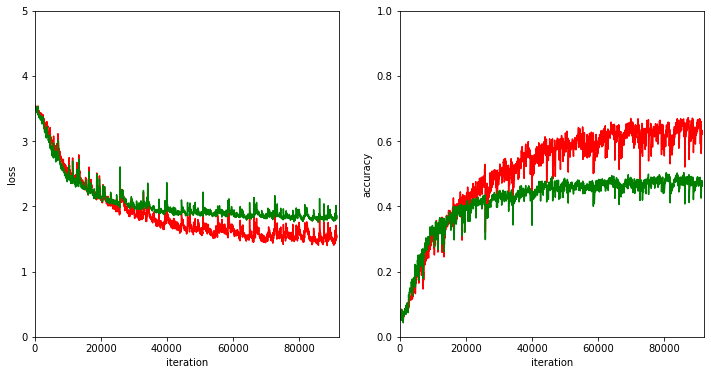

In [7]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,92000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,92000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 6 conv layers and 2 dense layers

In [8]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)    
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        



        

    


PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

In [9]:
learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 200

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

Epoch:0
Iteration:50
Time taken for the last 50 iterations: 47.54303312301636
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 43.216110944747925
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 43.86388945579529
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 44.86320352554321
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 44.65528607368469
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 43.8760404586792
Current training loss:3.4979169368743896
Current training accuracy:0.078125
Current validation loss:3.481032371520996
Current validation accuracy:0.061772603541612625
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 44.55283522605896
Current training loss:3.4578051567077637
Current training accuracy:0.072265625
Current validation loss:3.4300644397735596
Current validation accuracy:0.07520142942667007
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 44.30480194091797
Current training loss:3.46046805

Current training loss:2.926037073135376
Current training accuracy:0.19091796875
Current validation loss:2.802579402923584
Current validation accuracy:0.22381378710269928
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 44.49940371513367
Current training loss:3.025547981262207
Current training accuracy:0.14892578125
Current validation loss:2.9265031814575195
Current validation accuracy:0.18531781435012817
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 44.31314420700073
Current training loss:2.912353277206421
Current training accuracy:0.19384765625
Current validation loss:2.799314022064209
Current validation accuracy:0.21217547357082367
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 44.27608919143677
Current training loss:2.9345498085021973
Current training accuracy:0.20166015625
Current validation loss:2.80618953704834
Current validation accuracy:0.23992837965488434
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 44.47436833381653

Current training loss:2.770695686340332
Current training accuracy:0.2060546875
Current validation loss:2.6184957027435303
Current validation accuracy:0.2649955153465271
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 50.95521688461304
Current training loss:2.591388463973999
Current training accuracy:0.27197265625
Current validation loss:2.4595108032226562
Current validation accuracy:0.2981199622154236
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 51.054410219192505
Current training loss:2.6737759113311768
Current training accuracy:0.2470703125
Current validation loss:2.5952653884887695
Current validation accuracy:0.2587287425994873
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 51.01100730895996
Current training loss:2.5776243209838867
Current training accuracy:0.26025390625
Current validation loss:2.5231688022613525
Current validation accuracy:0.29364368319511414
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 49.978625297

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 50.955034494400024
Current training loss:2.3718438148498535
Current training accuracy:0.32568359375
Current validation loss:2.3353374004364014
Current validation accuracy:0.30796778202056885
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 51.06904101371765
Current training loss:2.329721212387085
Current training accuracy:0.31591796875
Current validation loss:2.389437675476074
Current validation accuracy:0.3205013573169708
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 49.96123957633972
Current training loss:2.347161293029785
Current training accuracy:0.34423828125
Current validation loss:2.4146530628204346
Current validation accuracy:0.32855865359306335
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 51.01009154319763
Current training loss:2.34053373336792
Current training accuracy:0.34033203125
Current validation loss:2.372405529022217
Current validation accuracy:0.314234554767

Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 50.10623574256897
Current training loss:2.46454119682312
Current training accuracy:0.322265625
Current validation loss:2.513824224472046
Current validation accuracy:0.2882721722126007
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 51.05340886116028
Current training loss:2.317425012588501
Current training accuracy:0.3349609375
Current validation loss:2.342783212661743
Current validation accuracy:0.3339301645755768
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 51.03222703933716
Current training loss:2.256309747695923
Current training accuracy:0.369140625
Current validation loss:2.2828643321990967
Current validation accuracy:0.3366159498691559
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 51.03447103500366
Current training loss:2.2108287811279297
Current training accuracy:0.39111328125
Current validation loss:2.225731372833252
Current validation accuracy:0.35541629791259766
Epo

Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 51.06191921234131
Current training loss:1.8680953979492188
Current training accuracy:0.48583984375
Current validation loss:2.0891876220703125
Current validation accuracy:0.3777976632118225
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 51.104007720947266
Current training loss:1.8278261423110962
Current training accuracy:0.49365234375
Current validation loss:2.048645257949829
Current validation accuracy:0.3957027792930603
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 50.991994857788086
Current training loss:1.869422197341919
Current training accuracy:0.48681640625
Current validation loss:2.0705854892730713
Current validation accuracy:0.3921217620372772
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 50.93518018722534
Current training loss:1.8046859502792358
Current training accuracy:0.5107421875
Current validation loss:2.0150845050811768
Current validation accuracy:0.4100268483

Current validation loss:2.016948938369751
Current validation accuracy:0.41271263360977173
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 52.550519704818726
Current training loss:1.7356497049331665
Current training accuracy:0.529296875
Current validation loss:2.064540147781372
Current validation accuracy:0.3930170238018036
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 52.67748808860779
Current training loss:1.702836275100708
Current training accuracy:0.5244140625
Current validation loss:2.089827537536621
Current validation accuracy:0.38854074478149414
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 52.19031238555908
Current training loss:1.7090988159179688
Current training accuracy:0.53369140625
Current validation loss:2.0248937606811523
Current validation accuracy:0.41181737184524536
Epoch:39
Iteration:10250
Time taken for the last 50 iterations: 53.492395877838135
Current training loss:1.7051143646240234
Current training accuracy:0.54

Current training loss:1.5021038055419922
Current training accuracy:0.60400390625
Current validation loss:1.9581735134124756
Current validation accuracy:0.4404655396938324
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 65.00623917579651
Current training loss:1.6244062185287476
Current training accuracy:0.54931640625
Current validation loss:2.066077709197998
Current validation accuracy:0.4082363545894623
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 66.95928120613098
Current training loss:1.5849770307540894
Current training accuracy:0.57177734375
Current validation loss:2.064753532409668
Current validation accuracy:0.4019695520401001
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 67.92598104476929
Current training loss:1.4430067539215088
Current training accuracy:0.6162109375
Current validation loss:2.003668785095215
Current validation accuracy:0.4288272261619568
Epoch:45
Iteration:11900
Time taken for the last 50 iterations: 68.9944248

Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 111.42708921432495
Current training loss:1.4596600532531738
Current training accuracy:0.6083984375
Current validation loss:2.0932488441467285
Current validation accuracy:0.4082363545894623
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 114.83281922340393
Current training loss:1.4195642471313477
Current training accuracy:0.6455078125
Current validation loss:2.035978317260742
Current validation accuracy:0.4136078655719757
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 117.6693058013916
Current training loss:1.397751808166504
Current training accuracy:0.65283203125
Current validation loss:2.0213472843170166
Current validation accuracy:0.42076992988586426
Epoch:51
Iteration:13500
Time taken for the last 50 iterations: 118.88052582740784
Current training loss:1.3841230869293213
Current training accuracy:0.6376953125
Current validation loss:2.0466971397399902
Current validation accuracy:0.423455

Current validation loss:1.9560420513153076
Current validation accuracy:0.4503133296966553
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 167.4533076286316
Current training loss:1.2691290378570557
Current training accuracy:0.69287109375
Current validation loss:2.000756025314331
Current validation accuracy:0.4368845224380493
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 168.68441009521484
Current training loss:1.1481162309646606
Current training accuracy:0.73779296875
Current validation loss:1.9188960790634155
Current validation accuracy:0.4637421667575836
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 169.60087513923645
Current training loss:1.1671147346496582
Current training accuracy:0.7314453125
Current validation loss:1.9291727542877197
Current validation accuracy:0.4583706259727478
Epoch:58
Iteration:15150
Time taken for the last 50 iterations: 167.1034767627716
Current training loss:1.4394426345825195
Current training accuracy:0.

KeyboardInterrupt: 

This won't give the desired results.

# Model with 7 conv layers

In [10]:
class PetCNN7(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),            
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),            
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv7 = nn.Sequential( nn.Dropout(0.5),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),            
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN7()
loss_function = nn.NLLLoss()


print(model1)
        

PetCNN7(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(32, 128,

In [11]:
learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 200

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

Epoch:0
Iteration:50
Time taken for the last 50 iterations: 13.14189887046814
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 12.98625898361206
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 13.2131507396698
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 13.247401237487793
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 15.406121969223022
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 14.780970573425293
Current training loss:3.4814412593841553
Current training accuracy:0.052734375
Current validation loss:3.4448082447052
Current validation accuracy:0.0626678615808487
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 15.052486896514893
Current training loss:3.5105223655700684
Current training accuracy:0.06787109375
Current validation loss:3.514301300048828
Current validation accuracy:0.057296328246593475
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 15.167978763580322
Current training loss:3.491

Current training loss:3.4298880100250244
Current training accuracy:0.068359375
Current validation loss:3.360152244567871
Current validation accuracy:0.07788719981908798
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 15.61442518234253
Current training loss:3.3827333450317383
Current training accuracy:0.08544921875
Current validation loss:3.2973263263702393
Current validation accuracy:0.09579230099916458
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 16.331554412841797
Current training loss:3.397815465927124
Current training accuracy:0.0751953125
Current validation loss:3.304309129714966
Current validation accuracy:0.09758280962705612
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 15.913973093032837
Current training loss:3.3839190006256104
Current training accuracy:0.0751953125
Current validation loss:3.2726290225982666
Current validation accuracy:0.09668755531311035
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 15.430658340454

Current training loss:3.3664357662200928
Current training accuracy:0.091796875
Current validation loss:3.2349493503570557
Current validation accuracy:0.10295434296131134
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 13.148984670639038
Current training loss:3.366316795349121
Current training accuracy:0.0712890625
Current validation loss:3.233678102493286
Current validation accuracy:0.12623097002506256
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 12.938951969146729
Current training loss:3.3595781326293945
Current training accuracy:0.0849609375
Current validation loss:3.2413735389709473
Current validation accuracy:0.0922112837433815
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 12.867817401885986
Current training loss:3.3641953468322754
Current training accuracy:0.0888671875
Current validation loss:3.277992010116577
Current validation accuracy:0.10205908864736557
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 12.694815874

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 13.062803983688354
Current training loss:3.3261940479278564
Current training accuracy:0.078125
Current validation loss:3.2195897102355957
Current validation accuracy:0.09131602197885513
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 13.135964393615723
Current training loss:3.3303029537200928
Current training accuracy:0.087890625
Current validation loss:3.2068750858306885
Current validation accuracy:0.09937331825494766
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 12.90718936920166
Current training loss:3.2719457149505615
Current training accuracy:0.10791015625
Current validation loss:3.1887905597686768
Current validation accuracy:0.11190689355134964
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 12.980784893035889
Current training loss:3.2697501182556152
Current training accuracy:0.09912109375
Current validation loss:3.180302858352661
Current validation accuracy:0.12444046884

Current validation loss:3.1156275272369385
Current validation accuracy:0.1280214935541153
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 14.941798210144043
Current training loss:3.2679173946380615
Current training accuracy:0.10009765625
Current validation loss:3.133242130279541
Current validation accuracy:0.1342882663011551
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 13.117621898651123
Current training loss:3.2253987789154053
Current training accuracy:0.12744140625
Current validation loss:3.0908703804016113
Current validation accuracy:0.16293643414974213
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 12.945914030075073
Current training loss:3.238957643508911
Current training accuracy:0.10791015625
Current validation loss:3.1267833709716797
Current validation accuracy:0.12712623178958893
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 13.119450092315674
Current training loss:3.261155843734741
Current training accuracy:0.1

Current training loss:3.235146999359131
Current training accuracy:0.119140625
Current validation loss:3.086836576461792
Current validation accuracy:0.14682184159755707
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 13.993263483047485
Current training loss:3.2021026611328125
Current training accuracy:0.1123046875
Current validation loss:3.0543360710144043
Current validation accuracy:0.15935541689395905
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 14.156895875930786
Current training loss:3.232001304626465
Current training accuracy:0.12353515625
Current validation loss:3.1058614253997803
Current validation accuracy:0.14055505394935608
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 14.329769134521484
Current training loss:3.179178237915039
Current training accuracy:0.1201171875
Current validation loss:3.090656280517578
Current validation accuracy:0.14234556257724762
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 14.441372871

Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 25.93887710571289
Current training loss:3.1585495471954346
Current training accuracy:0.12451171875
Current validation loss:2.989293336868286
Current validation accuracy:0.17457474768161774
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 26.599640369415283
Current training loss:3.138916015625
Current training accuracy:0.134765625
Current validation loss:2.997109889984131
Current validation accuracy:0.16741271317005157
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 27.435328245162964
Current training loss:3.1428213119506836
Current training accuracy:0.13525390625
Current validation loss:3.0189249515533447
Current validation accuracy:0.17099373042583466
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 27.54123044013977
Current training loss:3.193021059036255
Current training accuracy:0.1318359375
Current validation loss:3.0583808422088623
Current validation accuracy:0.1423455625

Current validation loss:2.94958233833313
Current validation accuracy:0.19695612788200378
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 39.385857343673706
Current training loss:3.0724377632141113
Current training accuracy:0.15283203125
Current validation loss:2.942284345626831
Current validation accuracy:0.2050134241580963
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 38.84038710594177
Current training loss:3.1213181018829346
Current training accuracy:0.1328125
Current validation loss:2.983795642852783
Current validation accuracy:0.1727842390537262
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 39.70893478393555
Current training loss:3.1357593536376953
Current training accuracy:0.14404296875
Current validation loss:2.989720582962036
Current validation accuracy:0.1933751106262207
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 39.65604782104492
Current training loss:3.0788660049438477
Current training accuracy:0.1552734

Current training loss:3.0930991172790527
Current training accuracy:0.1533203125
Current validation loss:2.947765827178955
Current validation accuracy:0.19695612788200378
Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 38.40499567985535
Current training loss:3.182398557662964
Current training accuracy:0.1396484375
Current validation loss:3.0673105716705322
Current validation accuracy:0.15666964650154114
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 38.991058588027954
Current training loss:3.1259047985076904
Current training accuracy:0.15576171875
Current validation loss:2.987555980682373
Current validation accuracy:0.18621307611465454
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 39.10984539985657
Current training loss:3.1472184658050537
Current training accuracy:0.14599609375
Current validation loss:2.981149911880493
Current validation accuracy:0.1817367970943451
Epoch:51
Iteration:13500
Time taken for the last 50 iterations: 39.31298

Epoch:57
Iteration:14950
Time taken for the last 50 iterations: 38.72636795043945
Current training loss:3.06128191947937
Current training accuracy:0.1484375
Current validation loss:2.89298939704895
Current validation accuracy:0.18979409337043762
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 38.39733290672302
Current training loss:3.087461471557617
Current training accuracy:0.150390625
Current validation loss:2.9386839866638184
Current validation accuracy:0.18979409337043762
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 38.581220388412476
Current training loss:3.0618913173675537
Current training accuracy:0.1630859375
Current validation loss:2.935065269470215
Current validation accuracy:0.17994628846645355
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 38.41424107551575
Current training loss:3.09464693069458
Current training accuracy:0.13818359375
Current validation loss:2.9492528438568115
Current validation accuracy:0.1763652712106704

Current validation loss:2.988610029220581
Current validation accuracy:0.18531781435012817
Epoch:63
Iteration:16600
Time taken for the last 50 iterations: 35.814950942993164
Current training loss:3.179987668991089
Current training accuracy:0.13623046875
Current validation loss:3.0160751342773438
Current validation accuracy:0.1817367970943451
Epoch:63
Iteration:16650
Time taken for the last 50 iterations: 36.017882108688354
Current training loss:3.116225004196167
Current training accuracy:0.15576171875
Current validation loss:2.9659597873687744
Current validation accuracy:0.184422567486763
Epoch:63
Iteration:16700
Time taken for the last 50 iterations: 35.86015176773071
Current training loss:3.146425724029541
Current training accuracy:0.1376953125
Current validation loss:2.9725968837738037
Current validation accuracy:0.18352730572223663
Epoch:64
Iteration:16750
Time taken for the last 50 iterations: 35.22178387641907
Current training loss:3.1280715465545654
Current training accuracy:0.13

Current training loss:3.0866799354553223
Current training accuracy:0.15673828125
Current validation loss:2.9278652667999268
Current validation accuracy:0.19516561925411224
Epoch:69
Iteration:18250
Time taken for the last 50 iterations: 35.443869829177856
Current training loss:3.0786116123199463
Current training accuracy:0.1533203125
Current validation loss:2.9147591590881348
Current validation accuracy:0.20769919455051422
Epoch:70
Iteration:18300
Time taken for the last 50 iterations: 34.46672558784485
Current training loss:3.0442850589752197
Current training accuracy:0.16650390625
Current validation loss:2.8642196655273438
Current validation accuracy:0.20680393278598785
Epoch:70
Iteration:18350
Time taken for the last 50 iterations: 35.11658000946045
Current training loss:3.0677289962768555
Current training accuracy:0.16357421875
Current validation loss:2.9033191204071045
Current validation accuracy:0.20411817729473114
Epoch:70
Iteration:18400
Time taken for the last 50 iterations: 35

Epoch:76
Iteration:19850
Time taken for the last 50 iterations: 33.981109380722046
Current training loss:3.316901683807373
Current training accuracy:0.09375
Current validation loss:3.2162981033325195
Current validation accuracy:0.11459265649318695
Epoch:76
Iteration:19900
Time taken for the last 50 iterations: 34.21777868270874
Current training loss:3.1431620121002197
Current training accuracy:0.14697265625
Current validation loss:3.0098092555999756
Current validation accuracy:0.18710832297801971
Epoch:76
Iteration:19950
Time taken for the last 50 iterations: 34.188374519348145
Current training loss:3.1178576946258545
Current training accuracy:0.142578125
Current validation loss:2.9314281940460205
Current validation accuracy:0.2085944563150406
Epoch:76
Iteration:20000
Time taken for the last 50 iterations: 34.158058643341064
Current training loss:3.0540771484375
Current training accuracy:0.1748046875
Current validation loss:2.9031617641448975
Current validation accuracy:0.2068039327859

Current validation loss:2.8916831016540527
Current validation accuracy:0.2050134241580963
Epoch:82
Iteration:21500
Time taken for the last 50 iterations: 33.97564768791199
Current training loss:3.046894073486328
Current training accuracy:0.1533203125
Current validation loss:2.8843488693237305
Current validation accuracy:0.19516561925411224
Epoch:82
Iteration:21550
Time taken for the last 50 iterations: 34.033132553100586
Current training loss:3.0376758575439453
Current training accuracy:0.16455078125
Current validation loss:2.885979413986206
Current validation accuracy:0.2175469994544983
Epoch:82
Iteration:21600
Time taken for the last 50 iterations: 33.885916233062744
Current training loss:3.0648059844970703
Current training accuracy:0.15185546875
Current validation loss:2.9074721336364746
Current validation accuracy:0.20680393278598785
Epoch:82
Iteration:21650
Time taken for the last 50 iterations: 34.104389905929565
Current training loss:2.9807076454162598
Current training accuracy:

Current training loss:2.9952852725982666
Current training accuracy:0.1787109375
Current validation loss:2.8618407249450684
Current validation accuracy:0.1996418982744217
Epoch:88
Iteration:23150
Time taken for the last 50 iterations: 33.356834173202515
Current training loss:2.993656635284424
Current training accuracy:0.169921875
Current validation loss:2.8627922534942627
Current validation accuracy:0.22381378710269928
Epoch:88
Iteration:23200
Time taken for the last 50 iterations: 33.329596757888794
Current training loss:2.9748668670654297
Current training accuracy:0.18017578125
Current validation loss:2.8515777587890625
Current validation accuracy:0.20411817729473114
Epoch:89
Iteration:23250
Time taken for the last 50 iterations: 32.663580656051636
Current training loss:2.9939568042755127
Current training accuracy:0.17626953125
Current validation loss:2.8581457138061523
Current validation accuracy:0.20769919455051422
Epoch:89
Iteration:23300
Time taken for the last 50 iterations: 33.4

Epoch:94
Iteration:24750
Time taken for the last 50 iterations: 33.34732532501221
Current training loss:3.0322935581207275
Current training accuracy:0.1650390625
Current validation loss:2.8916757106781006
Current validation accuracy:0.20769919455051422
Epoch:95
Iteration:24800
Time taken for the last 50 iterations: 32.606669187545776
Current training loss:3.0245327949523926
Current training accuracy:0.17236328125
Current validation loss:2.866377353668213
Current validation accuracy:0.1996418982744217
Epoch:95
Iteration:24850
Time taken for the last 50 iterations: 33.09857153892517
Current training loss:2.966980218887329
Current training accuracy:0.193359375
Current validation loss:2.8636629581451416
Current validation accuracy:0.21486122906208038
Epoch:95
Iteration:24900
Time taken for the last 50 iterations: 33.123018741607666
Current training loss:3.0252678394317627
Current training accuracy:0.1591796875
Current validation loss:2.8772189617156982
Current validation accuracy:0.2148612

Current validation loss:2.8710784912109375
Current validation accuracy:0.21665175259113312
Epoch:101
Iteration:26400
Time taken for the last 50 iterations: 31.668440341949463
Current training loss:3.0546987056732178
Current training accuracy:0.1533203125
Current validation loss:2.901954174041748
Current validation accuracy:0.20590868592262268
Epoch:101
Iteration:26450
Time taken for the last 50 iterations: 31.924325942993164
Current training loss:2.9606246948242188
Current training accuracy:0.19140625
Current validation loss:2.8187453746795654
Current validation accuracy:0.21575649082660675
Epoch:101
Iteration:26500
Time taken for the last 50 iterations: 31.897712230682373
Current training loss:2.9707648754119873
Current training accuracy:0.20068359375
Current validation loss:2.8439390659332275
Current validation accuracy:0.1960608810186386
Epoch:101
Iteration:26550
Time taken for the last 50 iterations: 32.290764570236206
Current training loss:2.9824416637420654
Current training accur

Epoch:107
Iteration:28000
Time taken for the last 50 iterations: 31.60502815246582
Current training loss:2.9538381099700928
Current training accuracy:0.1845703125
Current validation loss:2.819478988647461
Current validation accuracy:0.21307072043418884
Epoch:107
Iteration:28050
Time taken for the last 50 iterations: 31.661264896392822
Current training loss:3.0084171295166016
Current training accuracy:0.16748046875
Current validation loss:2.85689115524292
Current validation accuracy:0.20769919455051422
Epoch:107
Iteration:28100
Time taken for the last 50 iterations: 32.12922167778015
Current training loss:2.9118127822875977
Current training accuracy:0.18701171875
Current validation loss:2.771744728088379
Current validation accuracy:0.22202327847480774
Epoch:107
Iteration:28150
Time taken for the last 50 iterations: 32.15480828285217
Current training loss:2.944369316101074
Current training accuracy:0.19189453125
Current validation loss:2.809403657913208
Current validation accuracy:0.2264

Current validation loss:2.80945086479187
Current validation accuracy:0.22112801671028137
Epoch:113
Iteration:29650
Time taken for the last 50 iterations: 31.653385639190674
Current training loss:2.954542636871338
Current training accuracy:0.1806640625
Current validation loss:2.783219575881958
Current validation accuracy:0.22739480435848236
Epoch:113
Iteration:29700
Time taken for the last 50 iterations: 31.52388596534729
Current training loss:2.9656999111175537
Current training accuracy:0.17822265625
Current validation loss:2.8337810039520264
Current validation accuracy:0.2139659821987152
Epoch:113
Iteration:29750
Time taken for the last 50 iterations: 31.607406854629517
Current training loss:2.964284896850586
Current training accuracy:0.171875
Current validation loss:2.8324925899505615
Current validation accuracy:0.2139659821987152
Epoch:114
Iteration:29800
Time taken for the last 50 iterations: 31.03314781188965
Current training loss:2.975618600845337
Current training accuracy:0.1855

Epoch:119
Iteration:31250
Time taken for the last 50 iterations: 31.958914518356323
Current training loss:2.9681572914123535
Current training accuracy:0.1728515625
Current validation loss:2.766934633255005
Current validation accuracy:0.23366159200668335
Epoch:119
Iteration:31300
Time taken for the last 50 iterations: 31.91288709640503
Current training loss:2.9426913261413574
Current training accuracy:0.19384765625
Current validation loss:2.789311170578003
Current validation accuracy:0.22560429573059082
Epoch:120
Iteration:31350
Time taken for the last 50 iterations: 31.38240623474121
Current training loss:2.971169948577881
Current training accuracy:0.18505859375
Current validation loss:2.7951080799102783
Current validation accuracy:0.22560429573059082
Epoch:120
Iteration:31400
Time taken for the last 50 iterations: 31.78267765045166
Current training loss:2.9568474292755127
Current training accuracy:0.1884765625
Current validation loss:2.812457323074341
Current validation accuracy:0.224

Current training loss:2.8840434551239014
Current training accuracy:0.21533203125
Current validation loss:2.765162467956543
Current validation accuracy:0.23366159200668335
Epoch:126
Iteration:32900
Time taken for the last 50 iterations: 31.294655561447144
Current training loss:2.9149270057678223
Current training accuracy:0.19189453125
Current validation loss:2.7642605304718018
Current validation accuracy:0.2444046586751938
Epoch:126
Iteration:32950
Time taken for the last 50 iterations: 31.59208083152771
Current training loss:2.9184610843658447
Current training accuracy:0.2001953125
Current validation loss:2.7855329513549805
Current validation accuracy:0.23634736239910126
Epoch:126
Iteration:33000
Time taken for the last 50 iterations: 31.284274578094482
Current training loss:2.9415156841278076
Current training accuracy:0.18603515625
Current validation loss:2.7937192916870117
Current validation accuracy:0.21665175259113312
Epoch:126
Iteration:33050
Time taken for the last 50 iterations:

Current validation loss:2.788670539855957
Current validation accuracy:0.23634736239910126
Epoch:132
Iteration:34500
Time taken for the last 50 iterations: 30.735676765441895
Current training loss:2.9147918224334717
Current training accuracy:0.18994140625
Current validation loss:2.77836012840271
Current validation accuracy:0.24529990553855896
Epoch:132
Iteration:34550
Time taken for the last 50 iterations: 31.25498104095459
Current training loss:2.866572856903076
Current training accuracy:0.21044921875
Current validation loss:2.753492832183838
Current validation accuracy:0.24350939691066742
Epoch:132
Iteration:34600
Time taken for the last 50 iterations: 30.844711542129517
Current training loss:2.9234731197357178
Current training accuracy:0.18896484375
Current validation loss:2.7888388633728027
Current validation accuracy:0.22829006612300873
Epoch:132
Iteration:34650
Time taken for the last 50 iterations: 31.491207361221313
Current training loss:2.9065723419189453
Current training accur

Epoch:138
Iteration:36100
Time taken for the last 50 iterations: 30.73436403274536
Current training loss:2.9256415367126465
Current training accuracy:0.20703125
Current validation loss:2.8005638122558594
Current validation accuracy:0.22112801671028137
Epoch:138
Iteration:36150
Time taken for the last 50 iterations: 30.678523540496826
Current training loss:2.9266791343688965
Current training accuracy:0.19287109375
Current validation loss:2.7806360721588135
Current validation accuracy:0.22112801671028137
Epoch:138
Iteration:36200
Time taken for the last 50 iterations: 30.768913507461548
Current training loss:2.8539769649505615
Current training accuracy:0.2138671875
Current validation loss:2.7336580753326416
Current validation accuracy:0.2354521006345749
Epoch:138
Iteration:36250
Time taken for the last 50 iterations: 30.767893314361572
Current training loss:2.8895955085754395
Current training accuracy:0.2119140625
Current validation loss:2.7599854469299316
Current validation accuracy:0.2

Current training loss:2.843757390975952
Current training accuracy:0.2109375
Current validation loss:2.7314229011535645
Current validation accuracy:0.2470904141664505
Epoch:144
Iteration:37750
Time taken for the last 50 iterations: 31.154815912246704
Current training loss:2.8491361141204834
Current training accuracy:0.21630859375
Current validation loss:2.715768337249756
Current validation accuracy:0.25783348083496094
Epoch:144
Iteration:37800
Time taken for the last 50 iterations: 31.520341873168945
Current training loss:2.829183340072632
Current training accuracy:0.21142578125
Current validation loss:2.7440526485443115
Current validation accuracy:0.2318710833787918
Epoch:145
Iteration:37850
Time taken for the last 50 iterations: 31.041380643844604
Current training loss:2.958876848220825
Current training accuracy:0.20068359375
Current validation loss:2.8188045024871826
Current validation accuracy:0.21217547357082367
Epoch:145
Iteration:37900
Time taken for the last 50 iterations: 31.43

Current validation loss:2.7020576000213623
Current validation accuracy:0.2497761845588684
Epoch:150
Iteration:39350
Time taken for the last 50 iterations: 31.1363525390625
Current training loss:2.8724992275238037
Current training accuracy:0.21875
Current validation loss:2.7095139026641846
Current validation accuracy:0.2470904141664505
Epoch:150
Iteration:39400
Time taken for the last 50 iterations: 31.152273893356323
Current training loss:2.8578684329986572
Current training accuracy:0.21630859375
Current validation loss:2.737198829650879
Current validation accuracy:0.2202327698469162
Epoch:151
Iteration:39450
Time taken for the last 50 iterations: 30.817877769470215
Current training loss:2.8767781257629395
Current training accuracy:0.21240234375
Current validation loss:2.736675977706909
Current validation accuracy:0.24171888828277588
Epoch:151
Iteration:39500
Time taken for the last 50 iterations: 31.21825647354126
Current training loss:2.8237054347991943
Current training accuracy:0.23

Current training loss:2.887441635131836
Current training accuracy:0.201171875
Current validation loss:2.7619247436523438
Current validation accuracy:0.23455685377120972
Epoch:157
Iteration:41000
Time taken for the last 50 iterations: 30.619236707687378
Current training loss:2.8998360633850098
Current training accuracy:0.19677734375
Current validation loss:2.78669810295105
Current validation accuracy:0.2264995574951172
Epoch:157
Iteration:41050
Time taken for the last 50 iterations: 31.272164583206177
Current training loss:2.841878652572632
Current training accuracy:0.21923828125
Current validation loss:2.7163071632385254
Current validation accuracy:0.2524619400501251
Epoch:157
Iteration:41100
Time taken for the last 50 iterations: 31.11306118965149
Current training loss:2.869912624359131
Current training accuracy:0.205078125
Current validation loss:2.7707762718200684
Current validation accuracy:0.23366159200668335
Epoch:157
Iteration:41150
Time taken for the last 50 iterations: 30.8826

Epoch:163
Iteration:42600
Time taken for the last 50 iterations: 30.986764430999756
Current training loss:2.81811261177063
Current training accuracy:0.2314453125
Current validation loss:2.739410161972046
Current validation accuracy:0.2264995574951172
Epoch:163
Iteration:42650
Time taken for the last 50 iterations: 31.04393243789673
Current training loss:2.8201513290405273
Current training accuracy:0.22802734375
Current validation loss:2.7302138805389404
Current validation accuracy:0.2497761845588684
Epoch:163
Iteration:42700
Time taken for the last 50 iterations: 30.972702980041504
Current training loss:2.820405960083008
Current training accuracy:0.228515625
Current validation loss:2.7332165241241455
Current validation accuracy:0.23903311789035797
Epoch:163
Iteration:42750
Time taken for the last 50 iterations: 31.002135515213013
Current training loss:2.8721256256103516
Current training accuracy:0.2060546875
Current validation loss:2.766597270965576
Current validation accuracy:0.222918

Current validation loss:2.729837656021118
Current validation accuracy:0.23992837965488434
Epoch:169
Iteration:44250
Time taken for the last 50 iterations: 30.731369495391846
Current training loss:2.8704833984375
Current training accuracy:0.2021484375
Current validation loss:2.7155542373657227
Current validation accuracy:0.2470904141664505
Epoch:169
Iteration:44300
Time taken for the last 50 iterations: 30.657562494277954
Current training loss:2.8696227073669434
Current training accuracy:0.203125
Current validation loss:2.746016263961792
Current validation accuracy:0.23903311789035797
Epoch:169
Iteration:44350
Time taken for the last 50 iterations: 30.68911838531494
Current training loss:2.818481922149658
Current training accuracy:0.220703125
Current validation loss:2.7292022705078125
Current validation accuracy:0.2408236414194107
Epoch:170
Iteration:44400
Time taken for the last 50 iterations: 30.152137279510498
Current training loss:2.9455552101135254
Current training accuracy:0.1875


Current training loss:2.8208937644958496
Current training accuracy:0.2373046875
Current validation loss:2.7448558807373047
Current validation accuracy:0.2318710833787918
Epoch:175
Iteration:45900
Time taken for the last 50 iterations: 30.98691964149475
Current training loss:2.8352577686309814
Current training accuracy:0.208984375
Current validation loss:2.7308709621429443
Current validation accuracy:0.23903311789035797
Epoch:176
Iteration:45950
Time taken for the last 50 iterations: 30.62858819961548
Current training loss:2.8505008220672607
Current training accuracy:0.21630859375
Current validation loss:2.744586944580078
Current validation accuracy:0.24798567593097687
Epoch:176
Iteration:46000
Time taken for the last 50 iterations: 31.058263778686523
Current training loss:2.8342416286468506
Current training accuracy:0.2041015625
Current validation loss:2.729848861694336
Current validation accuracy:0.2444046586751938
Epoch:176
Iteration:46050
Time taken for the last 50 iterations: 30.75

Epoch:181
Iteration:47500
Time taken for the last 50 iterations: 30.53182888031006
Current training loss:2.8248960971832275
Current training accuracy:0.2119140625
Current validation loss:2.74344539642334
Current validation accuracy:0.2318710833787918
Epoch:182
Iteration:47550
Time taken for the last 50 iterations: 30.06741738319397
Current training loss:2.866328239440918
Current training accuracy:0.22021484375
Current validation loss:2.7554755210876465
Current validation accuracy:0.23455685377120972
Epoch:182
Iteration:47600
Time taken for the last 50 iterations: 30.528581619262695
Current training loss:2.857808828353882
Current training accuracy:0.21923828125
Current validation loss:2.7219526767730713
Current validation accuracy:0.25962400436401367
Epoch:182
Iteration:47650
Time taken for the last 50 iterations: 30.406413316726685
Current training loss:2.824204683303833
Current training accuracy:0.2236328125
Current validation loss:2.7220370769500732
Current validation accuracy:0.2461

Current validation loss:2.7489798069000244
Current validation accuracy:0.24171888828277588
Epoch:188
Iteration:49150
Time taken for the last 50 iterations: 30.344294548034668
Current training loss:2.830221176147461
Current training accuracy:0.22607421875
Current validation loss:2.697416305541992
Current validation accuracy:0.2506714463233948
Epoch:188
Iteration:49200
Time taken for the last 50 iterations: 30.383578538894653
Current training loss:2.8329756259918213
Current training accuracy:0.2333984375
Current validation loss:2.70082688331604
Current validation accuracy:0.2587287425994873
Epoch:188
Iteration:49250
Time taken for the last 50 iterations: 37.69114112854004
Current training loss:2.8109660148620605
Current training accuracy:0.22509765625
Current validation loss:2.6889283657073975
Current validation accuracy:0.25425246357917786
Epoch:188
Iteration:49300
Time taken for the last 50 iterations: 33.04780602455139
Current training loss:2.836247682571411
Current training accuracy:

Current training loss:2.8178939819335938
Current training accuracy:0.2294921875
Current validation loss:2.6904280185699463
Current validation accuracy:0.2470904141664505
Epoch:194
Iteration:50800
Time taken for the last 50 iterations: 37.251880407333374
Current training loss:2.85408353805542
Current training accuracy:0.21142578125
Current validation loss:2.71755313873291
Current validation accuracy:0.24350939691066742
Epoch:194
Iteration:50850
Time taken for the last 50 iterations: 37.33159613609314
Current training loss:2.8320562839508057
Current training accuracy:0.208984375
Current validation loss:2.712747812271118
Current validation accuracy:0.23724260926246643
Epoch:195
Iteration:50900
Time taken for the last 50 iterations: 36.45206332206726
Current training loss:2.920285224914551
Current training accuracy:0.18408203125
Current validation loss:2.8543360233306885
Current validation accuracy:0.22112801671028137
Epoch:195
Iteration:50950
Time taken for the last 50 iterations: 37.2217

In [12]:
num_epochs=300

start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                


Epoch:0
Iteration:52250
Time taken for the last 50 iterations: 30.84882164001465
Epoch:0
Iteration:52300
Time taken for the last 50 iterations: 33.520944595336914
Epoch:0
Iteration:52350
Time taken for the last 50 iterations: 36.529250383377075
Epoch:0
Iteration:52400
Time taken for the last 50 iterations: 39.65213894844055
Epoch:0
Iteration:52450
Time taken for the last 50 iterations: 39.089216470718384
Epoch:1
Iteration:52500
Time taken for the last 50 iterations: 37.916656494140625
Current training loss:2.8446106910705566
Current training accuracy:0.2119140625
Current validation loss:2.7378454208374023
Current validation accuracy:0.23634736239910126
Epoch:1
Iteration:52550
Time taken for the last 50 iterations: 41.45891213417053
Current training loss:2.8632988929748535
Current training accuracy:0.21337890625
Current validation loss:2.766479253768921
Current validation accuracy:0.23008057475090027
Epoch:1
Iteration:52600
Time taken for the last 50 iterations: 40.016353368759155
Curre

Epoch:7
Iteration:54050
Time taken for the last 50 iterations: 36.4457471370697
Current training loss:2.8362300395965576
Current training accuracy:0.19921875
Current validation loss:2.7193753719329834
Current validation accuracy:0.24261415004730225
Epoch:7
Iteration:54100
Time taken for the last 50 iterations: 37.172884464263916
Current training loss:2.7946763038635254
Current training accuracy:0.24072265625
Current validation loss:2.6916539669036865
Current validation accuracy:0.2444046586751938
Epoch:7
Iteration:54150
Time taken for the last 50 iterations: 37.17757534980774
Current training loss:2.7991652488708496
Current training accuracy:0.234375
Current validation loss:2.683695077896118
Current validation accuracy:0.2381378710269928
Epoch:7
Iteration:54200
Time taken for the last 50 iterations: 37.14500403404236
Current training loss:2.766995429992676
Current training accuracy:0.236328125
Current validation loss:2.6862833499908447
Current validation accuracy:0.25783348083496094
Ep

Current validation loss:2.7437398433685303
Current validation accuracy:0.2381378710269928
Epoch:13
Iteration:55700
Time taken for the last 50 iterations: 36.7995867729187
Current training loss:2.8004631996154785
Current training accuracy:0.2197265625
Current validation loss:2.707538604736328
Current validation accuracy:0.24529990553855896
Epoch:13
Iteration:55750
Time taken for the last 50 iterations: 36.87147259712219
Current training loss:2.802893877029419
Current training accuracy:0.232421875
Current validation loss:2.706648826599121
Current validation accuracy:0.24529990553855896
Epoch:13
Iteration:55800
Time taken for the last 50 iterations: 36.78348970413208
Current training loss:2.864093780517578
Current training accuracy:0.19873046875
Current validation loss:2.7339885234832764
Current validation accuracy:0.24350939691066742
Epoch:13
Iteration:55850
Time taken for the last 50 iterations: 36.808417558670044
Current training loss:2.737689971923828
Current training accuracy:0.25585

Current training loss:2.7856364250183105
Current training accuracy:0.22900390625
Current validation loss:2.660505771636963
Current validation accuracy:0.25962400436401367
Epoch:19
Iteration:57350
Time taken for the last 50 iterations: 36.880608797073364
Current training loss:2.8053700923919678
Current training accuracy:0.224609375
Current validation loss:2.687445640563965
Current validation accuracy:0.25693821907043457
Epoch:19
Iteration:57400
Time taken for the last 50 iterations: 36.80155658721924
Current training loss:2.8314032554626465
Current training accuracy:0.21533203125
Current validation loss:2.6929407119750977
Current validation accuracy:0.24888093769550323
Epoch:20
Iteration:57450
Time taken for the last 50 iterations: 36.00889730453491
Current training loss:2.772102117538452
Current training accuracy:0.22607421875
Current validation loss:2.690131187438965
Current validation accuracy:0.24798567593097687
Epoch:20
Iteration:57500
Time taken for the last 50 iterations: 36.8896

Epoch:25
Iteration:58950
Time taken for the last 50 iterations: 36.84519934654236
Current training loss:2.808546781539917
Current training accuracy:0.2236328125
Current validation loss:2.7493057250976562
Current validation accuracy:0.22739480435848236
Epoch:26
Iteration:59000
Time taken for the last 50 iterations: 36.09725069999695
Current training loss:2.8232011795043945
Current training accuracy:0.21728515625
Current validation loss:2.754169464111328
Current validation accuracy:0.2264995574951172
Epoch:26
Iteration:59050
Time taken for the last 50 iterations: 36.767401933670044
Current training loss:2.773697853088379
Current training accuracy:0.24267578125
Current validation loss:2.7000036239624023
Current validation accuracy:0.2318710833787918
Epoch:26
Iteration:59100
Time taken for the last 50 iterations: 36.747050046920776
Current training loss:2.8035151958465576
Current training accuracy:0.2265625
Current validation loss:2.7066497802734375
Current validation accuracy:0.2479856759

Current validation loss:2.687765121459961
Current validation accuracy:0.25425246357917786
Epoch:32
Iteration:60600
Time taken for the last 50 iterations: 36.423011302948
Current training loss:2.729314088821411
Current training accuracy:0.23583984375
Current validation loss:2.652682304382324
Current validation accuracy:0.25693821907043457
Epoch:32
Iteration:60650
Time taken for the last 50 iterations: 37.01755976676941
Current training loss:2.7561798095703125
Current training accuracy:0.240234375
Current validation loss:2.6849045753479004
Current validation accuracy:0.2506714463233948
Epoch:32
Iteration:60700
Time taken for the last 50 iterations: 37.00003242492676
Current training loss:2.7326502799987793
Current training accuracy:0.236328125
Current validation loss:2.6434104442596436
Current validation accuracy:0.2587287425994873
Epoch:32
Iteration:60750
Time taken for the last 50 iterations: 36.91363978385925
Current training loss:2.739009141921997
Current training accuracy:0.2421875


Current training loss:2.8394224643707275
Current training accuracy:0.22021484375
Current validation loss:2.703982353210449
Current validation accuracy:0.2470904141664505
Epoch:38
Iteration:62250
Time taken for the last 50 iterations: 36.85057759284973
Current training loss:2.8169026374816895
Current training accuracy:0.224609375
Current validation loss:2.69399356842041
Current validation accuracy:0.261414498090744
Epoch:38
Iteration:62300
Time taken for the last 50 iterations: 36.804261684417725
Current training loss:2.797248601913452
Current training accuracy:0.2294921875
Current validation loss:2.667909860610962
Current validation accuracy:0.2685765326023102
Epoch:38
Iteration:62350
Time taken for the last 50 iterations: 36.84244179725647
Current training loss:2.801685094833374
Current training accuracy:0.220703125
Current validation loss:2.6597695350646973
Current validation accuracy:0.2551477253437042
Epoch:39
Iteration:62400
Time taken for the last 50 iterations: 36.11574530601501

Epoch:44
Iteration:63850
Time taken for the last 50 iterations: 36.75481605529785
Current training loss:2.751981258392334
Current training accuracy:0.22998046875
Current validation loss:2.670219898223877
Current validation accuracy:0.2533572018146515
Epoch:44
Iteration:63900
Time taken for the last 50 iterations: 36.82067084312439
Current training loss:2.735555648803711
Current training accuracy:0.2373046875
Current validation loss:2.660691499710083
Current validation accuracy:0.25962400436401367
Epoch:45
Iteration:63950
Time taken for the last 50 iterations: 36.23282432556152
Current training loss:3.174130439758301
Current training accuracy:0.14892578125
Current validation loss:3.0905961990356445
Current validation accuracy:0.1665174514055252
Epoch:45
Iteration:64000
Time taken for the last 50 iterations: 36.76411771774292
Current training loss:2.8794360160827637
Current training accuracy:0.22412109375
Current validation loss:2.7215194702148438
Current validation accuracy:0.2578334808

Current validation loss:2.6602344512939453
Current validation accuracy:0.2649955153465271
Epoch:50
Iteration:65500
Time taken for the last 50 iterations: 36.59384894371033
Current training loss:2.766176462173462
Current training accuracy:0.23681640625
Current validation loss:2.673384189605713
Current validation accuracy:0.2560429871082306
Epoch:51
Iteration:65550
Time taken for the last 50 iterations: 35.91235566139221
Current training loss:2.731271982192993
Current training accuracy:0.23876953125
Current validation loss:2.6704273223876953
Current validation accuracy:0.26320502161979675
Epoch:51
Iteration:65600
Time taken for the last 50 iterations: 36.59654426574707
Current training loss:2.789564847946167
Current training accuracy:0.20849609375
Current validation loss:2.674243450164795
Current validation accuracy:0.2408236414194107
Epoch:51
Iteration:65650
Time taken for the last 50 iterations: 36.66166543960571
Current training loss:2.789830207824707
Current training accuracy:0.22216

Current training loss:2.755319356918335
Current training accuracy:0.2314453125
Current validation loss:2.7211523056030273
Current validation accuracy:0.23724260926246643
Epoch:57
Iteration:67150
Time taken for the last 50 iterations: 36.48945140838623
Current training loss:2.785904884338379
Current training accuracy:0.2421875
Current validation loss:2.6881070137023926
Current validation accuracy:0.261414498090744
Epoch:57
Iteration:67200
Time taken for the last 50 iterations: 36.449209213256836
Current training loss:2.7697746753692627
Current training accuracy:0.2451171875
Current validation loss:2.648728847503662
Current validation accuracy:0.27484333515167236
Epoch:57
Iteration:67250
Time taken for the last 50 iterations: 36.54505515098572
Current training loss:2.7029192447662354
Current training accuracy:0.2490234375
Current validation loss:2.641138792037964
Current validation accuracy:0.2524619400501251
Epoch:57
Iteration:67300
Time taken for the last 50 iterations: 36.506564855575

Epoch:63
Iteration:68750
Time taken for the last 50 iterations: 36.37313652038574
Current training loss:2.7614047527313232
Current training accuracy:0.24072265625
Current validation loss:2.6878209114074707
Current validation accuracy:0.25783348083496094
Epoch:63
Iteration:68800
Time taken for the last 50 iterations: 36.45703601837158
Current training loss:2.7439074516296387
Current training accuracy:0.23828125
Current validation loss:2.6525869369506836
Current validation accuracy:0.25962400436401367
Epoch:63
Iteration:68850
Time taken for the last 50 iterations: 36.561216831207275
Current training loss:2.7347450256347656
Current training accuracy:0.24072265625
Current validation loss:2.649691581726074
Current validation accuracy:0.26678603887557983
Epoch:63
Iteration:68900
Time taken for the last 50 iterations: 36.69409394264221
Current training loss:2.733551025390625
Current training accuracy:0.24169921875
Current validation loss:2.6438918113708496
Current validation accuracy:0.266786

Current validation loss:2.6948113441467285
Current validation accuracy:0.2524619400501251
Epoch:69
Iteration:70400
Time taken for the last 50 iterations: 36.84375238418579
Current training loss:2.7561633586883545
Current training accuracy:0.23876953125
Current validation loss:2.6686720848083496
Current validation accuracy:0.26051923632621765
Epoch:69
Iteration:70450
Time taken for the last 50 iterations: 36.74320650100708
Current training loss:2.770094394683838
Current training accuracy:0.228515625
Current validation loss:2.6795647144317627
Current validation accuracy:0.2497761845588684
Epoch:70
Iteration:70500
Time taken for the last 50 iterations: 36.18435597419739
Current training loss:2.7247233390808105
Current training accuracy:0.25146484375
Current validation loss:2.62736177444458
Current validation accuracy:0.2676813006401062
Epoch:70
Iteration:70550
Time taken for the last 50 iterations: 36.81048345565796
Current training loss:2.696882486343384
Current training accuracy:0.25146

Current training loss:2.7569148540496826
Current training accuracy:0.2333984375
Current validation loss:2.6799111366271973
Current validation accuracy:0.24171888828277588
Epoch:76
Iteration:72050
Time taken for the last 50 iterations: 35.99859428405762
Current training loss:2.818934679031372
Current training accuracy:0.21826171875
Current validation loss:2.687223196029663
Current validation accuracy:0.2408236414194107
Epoch:76
Iteration:72100
Time taken for the last 50 iterations: 36.56120157241821
Current training loss:2.7855334281921387
Current training accuracy:0.23193359375
Current validation loss:2.6779308319091797
Current validation accuracy:0.24350939691066742
Epoch:76
Iteration:72150
Time taken for the last 50 iterations: 36.719868183135986
Current training loss:2.7475569248199463
Current training accuracy:0.24609375
Current validation loss:2.674517869949341
Current validation accuracy:0.24619516730308533
Epoch:76
Iteration:72200
Time taken for the last 50 iterations: 36.580196

Epoch:82
Iteration:73650
Time taken for the last 50 iterations: 35.95923376083374
Current training loss:2.7827024459838867
Current training accuracy:0.24267578125
Current validation loss:2.7100226879119873
Current validation accuracy:0.2506714463233948
Epoch:82
Iteration:73700
Time taken for the last 50 iterations: 36.9168438911438
Current training loss:2.745687484741211
Current training accuracy:0.2548828125
Current validation loss:2.6600139141082764
Current validation accuracy:0.24619516730308533
Epoch:82
Iteration:73750
Time taken for the last 50 iterations: 36.80104112625122
Current training loss:2.762054204940796
Current training accuracy:0.236328125
Current validation loss:2.6492223739624023
Current validation accuracy:0.2551477253437042
Epoch:82
Iteration:73800
Time taken for the last 50 iterations: 36.881906032562256
Current training loss:2.7380571365356445
Current training accuracy:0.2353515625
Current validation loss:2.63535737991333
Current validation accuracy:0.262309759855

Current validation loss:2.6475367546081543
Current validation accuracy:0.2712623178958893
Epoch:88
Iteration:75300
Time taken for the last 50 iterations: 36.84615349769592
Current training loss:2.7574028968811035
Current training accuracy:0.23779296875
Current validation loss:2.6573853492736816
Current validation accuracy:0.25962400436401367
Epoch:88
Iteration:75350
Time taken for the last 50 iterations: 36.99048686027527
Current training loss:2.744403839111328
Current training accuracy:0.2373046875
Current validation loss:2.6665713787078857
Current validation accuracy:0.24798567593097687
Epoch:88
Iteration:75400
Time taken for the last 50 iterations: 37.1192512512207
Current training loss:2.6691057682037354
Current training accuracy:0.2431640625
Current validation loss:2.5914762020111084
Current validation accuracy:0.2649955153465271
Epoch:89
Iteration:75450
Time taken for the last 50 iterations: 36.39014935493469
Current training loss:2.913710355758667
Current training accuracy:0.191

Current training loss:2.7497992515563965
Current training accuracy:0.24169921875
Current validation loss:2.6702582836151123
Current validation accuracy:0.2524619400501251
Epoch:94
Iteration:76950
Time taken for the last 50 iterations: 36.833829402923584
Current training loss:2.7204909324645996
Current training accuracy:0.2431640625
Current validation loss:2.6429600715637207
Current validation accuracy:0.2641002833843231
Epoch:95
Iteration:77000
Time taken for the last 50 iterations: 36.21477293968201
Current training loss:3.440443754196167
Current training accuracy:0.1123046875
Current validation loss:3.3425726890563965
Current validation accuracy:0.11459265649318695
Epoch:95
Iteration:77050
Time taken for the last 50 iterations: 36.788108110427856
Current training loss:2.7476906776428223
Current training accuracy:0.234375
Current validation loss:2.6611225605010986
Current validation accuracy:0.2551477253437042
Epoch:95
Iteration:77100
Time taken for the last 50 iterations: 37.10323762

Epoch:100
Iteration:78550
Time taken for the last 50 iterations: 36.82903575897217
Current training loss:2.737762451171875
Current training accuracy:0.23681640625
Current validation loss:2.64475154876709
Current validation accuracy:0.2587287425994873
Epoch:101
Iteration:78600
Time taken for the last 50 iterations: 36.080166816711426
Current training loss:2.7438559532165527
Current training accuracy:0.25439453125
Current validation loss:2.6848905086517334
Current validation accuracy:0.2551477253437042
Epoch:101
Iteration:78650
Time taken for the last 50 iterations: 37.038952589035034
Current training loss:2.740358829498291
Current training accuracy:0.2451171875
Current validation loss:2.6632180213928223
Current validation accuracy:0.2533572018146515
Epoch:101
Iteration:78700
Time taken for the last 50 iterations: 37.102163314819336
Current training loss:2.770435333251953
Current training accuracy:0.2255859375
Current validation loss:2.6971328258514404
Current validation accuracy:0.25783

Current validation loss:2.6897695064544678
Current validation accuracy:0.2524619400501251
Epoch:107
Iteration:80200
Time taken for the last 50 iterations: 36.9588348865509
Current training loss:2.799056053161621
Current training accuracy:0.228515625
Current validation loss:2.7370715141296387
Current validation accuracy:0.25425246357917786
Epoch:107
Iteration:80250
Time taken for the last 50 iterations: 37.184600591659546
Current training loss:2.7879998683929443
Current training accuracy:0.23486328125
Current validation loss:2.713874101638794
Current validation accuracy:0.25693821907043457
Epoch:107
Iteration:80300
Time taken for the last 50 iterations: 37.16596841812134
Current training loss:2.729919672012329
Current training accuracy:0.24755859375
Current validation loss:2.6688971519470215
Current validation accuracy:0.24798567593097687
Epoch:107
Iteration:80350
Time taken for the last 50 iterations: 37.06184720993042
Current training loss:2.8175554275512695
Current training accuracy:

Current training loss:2.7963128089904785
Current training accuracy:0.21875
Current validation loss:2.7039270401000977
Current validation accuracy:0.24888093769550323
Epoch:113
Iteration:81850
Time taken for the last 50 iterations: 37.35711455345154
Current training loss:2.757110357284546
Current training accuracy:0.240234375
Current validation loss:2.6597769260406494
Current validation accuracy:0.2587287425994873
Epoch:113
Iteration:81900
Time taken for the last 50 iterations: 37.03800940513611
Current training loss:2.7391698360443115
Current training accuracy:0.24560546875
Current validation loss:2.6659185886383057
Current validation accuracy:0.24888093769550323
Epoch:113
Iteration:81950
Time taken for the last 50 iterations: 38.073830127716064


KeyboardInterrupt: 

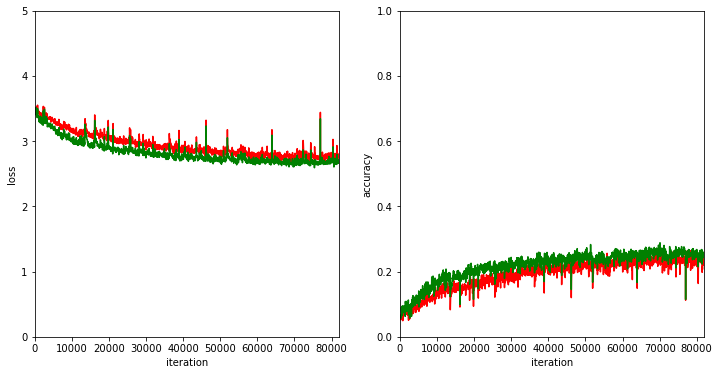

In [13]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,82000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,82000)
acc_graph.set_ylim(0,1)

plt.show() 